In [2]:
import os
import pandas as pd
import numpy as np
import cv2
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.transforms import ToTensor
from PIL import Image
import os
# from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
from torchvision import transforms
from torchinfo import summary
import timm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!pip install segmentation-models-pytorch


  Obtaining dependency information for segmentation-models-pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 8.1 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.resize = resize
        self.transform = transform
        self.images = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.images)
    
    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, self.resize)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        # lower boundary RED color range values; Hue (0 - 10)
        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])
        # upper boundary RED color range values; Hue (160 - 180)
        lower2 = np.array([160,100,20])
        upper2 = np.array([179,255,255])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)
        
        red_mask = lower_mask + upper_mask;
        red_mask[red_mask != 0] = 1

        # boundary GREEN color range values; Hue (36 - 70)
        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255, 255))
        green_mask[green_mask != 0] = 2

        full_mask = cv2.bitwise_or(red_mask, green_mask)
#         full_mask = full_mask.astype(np.float)
        full_mask = np.expand_dims(full_mask, axis=-1) 
        full_mask = full_mask.astype(np.uint8)
#         print(full_mask.shape)
        return full_mask

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = cv2.imread(img_path)  # Đọc ảnh dưới dạng BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert sang RGB
        label = self.read_mask(label_path)  
        image = cv2.resize(image, self.resize)
        if self.transform:
            image = self.transform(image)
        return image, label

    def show_image(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = plt.imread(img_path)
        label = plt.imread(label_path)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title('Image')
        axs[1].imshow(label)
        axs[1].set_title('Label')
        plt.show()

In [5]:
image_path = []
TRAIN_DIR = '/kaggle/input/bkai-igh-neopolyp/train/train'
for root, dirs, files in os.walk(TRAIN_DIR):
    # iterate over 1000 images
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        image_path.append(path)
len(image_path)

1000

In [6]:
mask_path = []
TRAIN_MASK_DIR = '/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt'
for root, dirs, files in os.walk(TRAIN_MASK_DIR):
    #iterate over 1000 masks
    for file in files:
        # obtain the path"
        path = os.path.join(root,file)
        # add path to the list
        mask_path.append(path)
len(mask_path)

1000

In [7]:
dataset = CustomImageDataset(img_dir= TRAIN_DIR,
                             label_dir= TRAIN_MASK_DIR,
                             resize= (256,256),
                             transform = None)

In [8]:
import segmentation_models_pytorch as smp


model = smp.UnetPlusPlus(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3     
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 237MB/s] 


In [9]:
batch_size = 8
images_data = []
labels_data = []
for x,y in dataset:
    images_data.append(x)
    labels_data.append(y)


In [10]:
class CustomDataset(CustomImageDataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        image = self.data[index]
        label = self.targets[index]
        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed['image'].float()
            label = transformed['mask'].float()
            label = label.permute(2, 0, 1)
        return image, label
    def __len__(self):
        return len(self.data)

    
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])
# Split the dataset into training and validation sets
train_size = int(0.9 * len(images_data))
val_size = len(images_data) - train_size
train_dataset = CustomDataset(images_data[:train_size], labels_data[:train_size], transform=train_transform)
val_dataset = CustomDataset(images_data[train_size:], labels_data[train_size:], transform=val_transform)
# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataset))
print(len(val_dataset))

900
100


Image:  torch.Size([3, 256, 256]) Label:  torch.Size([1, 256, 256])


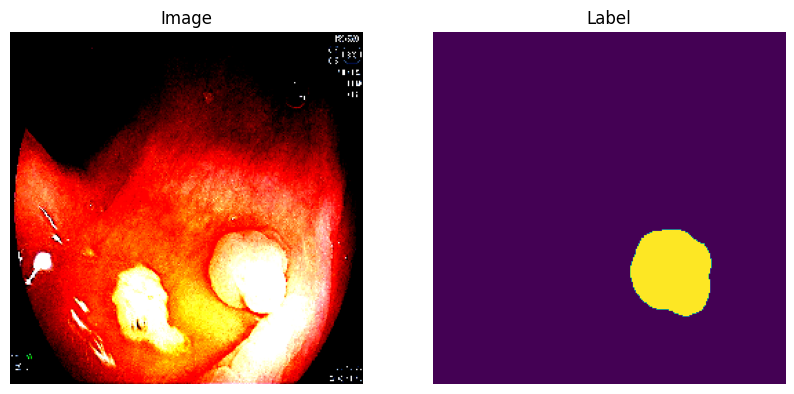

In [11]:
image,label = train_dataset[2]
print('Image: ', image.shape, 'Label: ', label.shape)

label_array = label.permute(1, 2, 0).numpy()
image_array = image.permute(1, 2, 0).numpy()
# Create a figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_array)
axs[0].set_title('Image')
axs[0].axis('off')  

axs[1].imshow(label_array)
axs[1].set_title('Label')
axs[1].axis('off')  

plt.show()

In [12]:
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
color_dict= {0: (0, 0, 0),
             1: (255, 0, 0),
             2: (0, 255, 0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))
#     print(output.shape)
    for k in color_dict.keys():
        output[mask==k] = color_dict[k]

    return np.uint8(output)    

In [14]:
!pip install wandb
import wandb
!wandb login 'cf3d72434022f1be5f7f85f08bff3743edefdf49'

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [15]:
wandb.init(
    project = 'DL_Neopolyp'
)

wandb: Currently logged in as: lengocbinh09062003 (hust_dsai). Use `wandb login --relogin` to force relogin


Epoch [1/125], Loss: 0.6425951490
Save new model


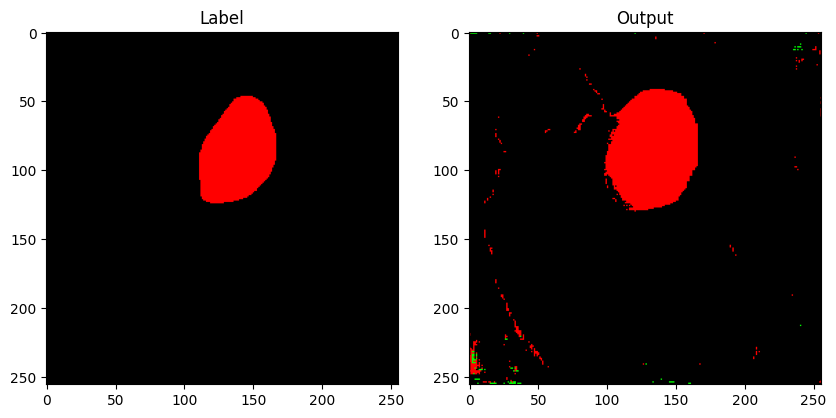

Epoch [2/125], Loss: 0.3353914320
Save new model


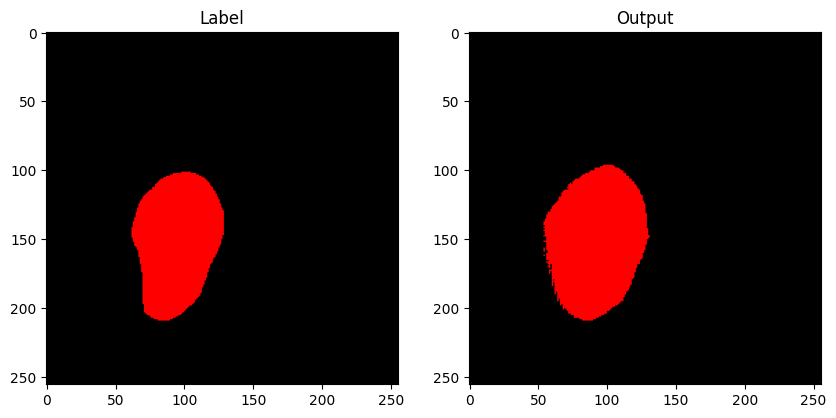

Epoch [3/125], Loss: 0.1978084067
Save new model


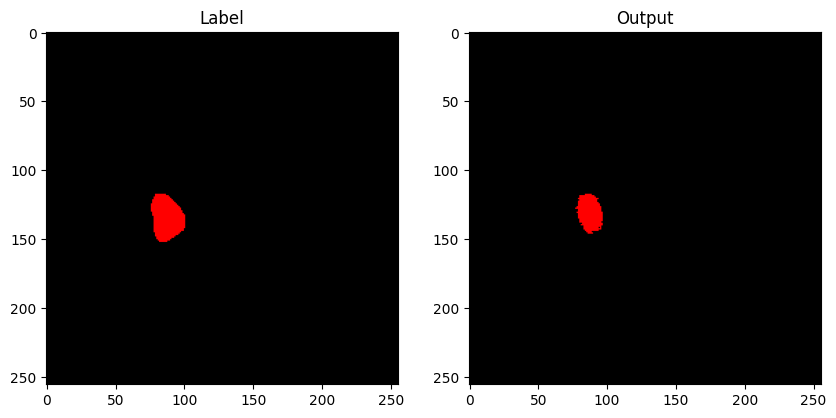

Epoch [4/125], Loss: 0.1481370513
Save new model


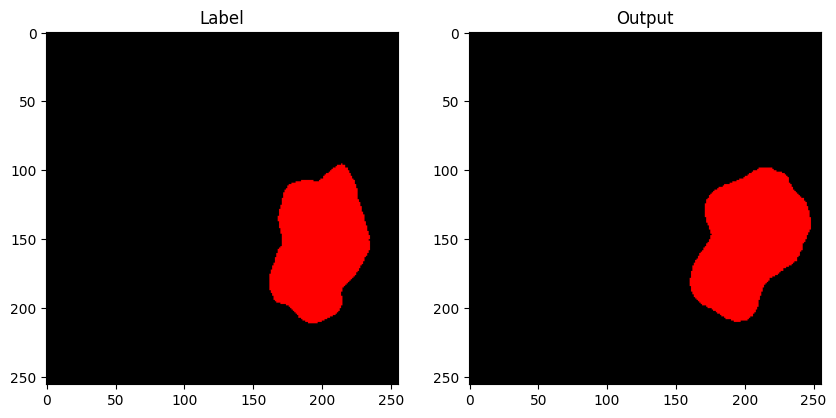

Epoch [5/125], Loss: 0.1139137498
Save new model


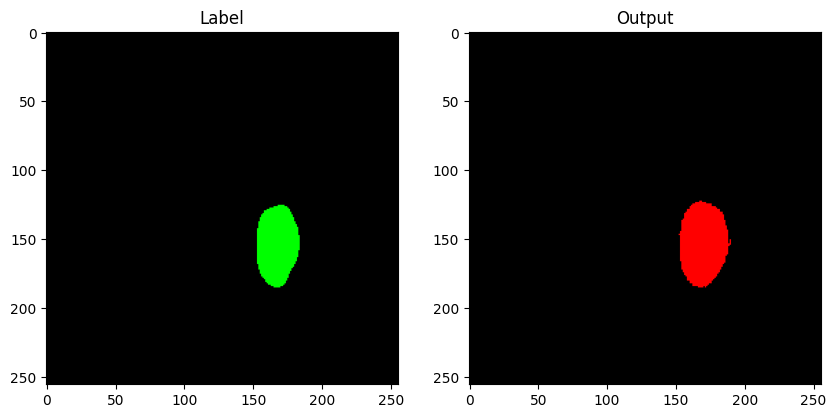

Epoch [6/125], Loss: 0.0965391673
Save new model


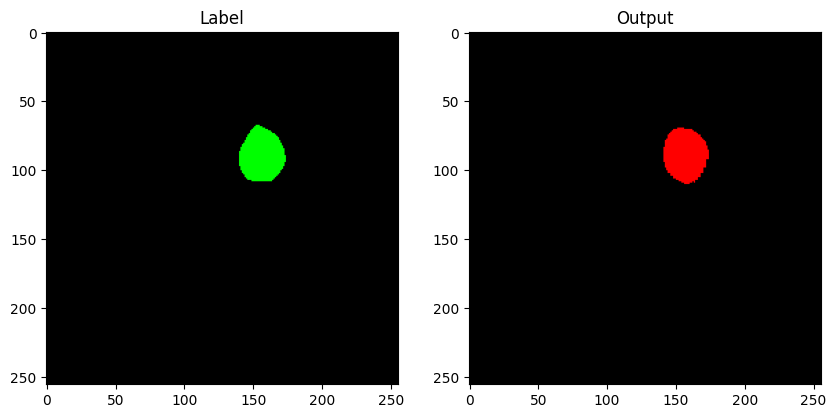

Epoch [7/125], Loss: 0.0864749264
Save new model


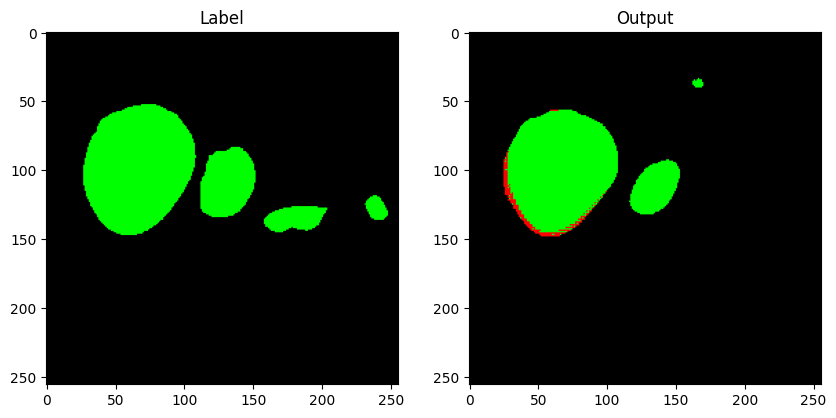

Epoch [8/125], Loss: 0.0759144196
Save new model


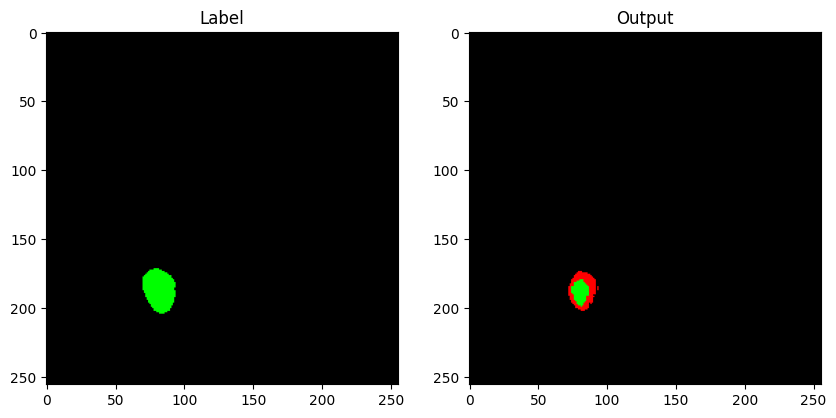

Epoch [9/125], Loss: 0.0710014987
Save new model


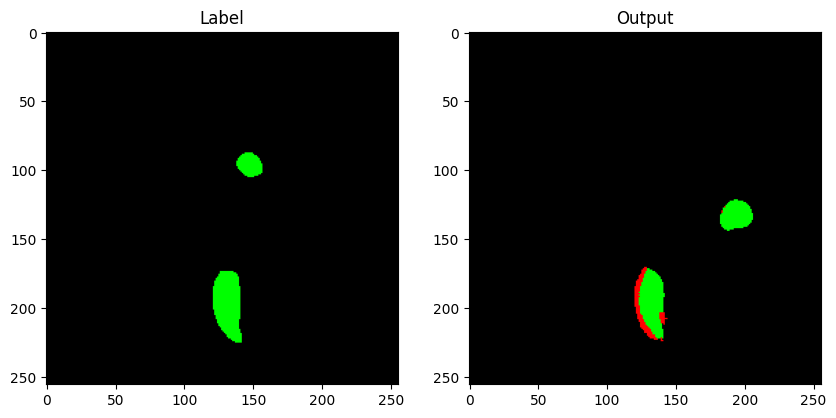

Epoch [10/125], Loss: 0.0651243071
Save new model


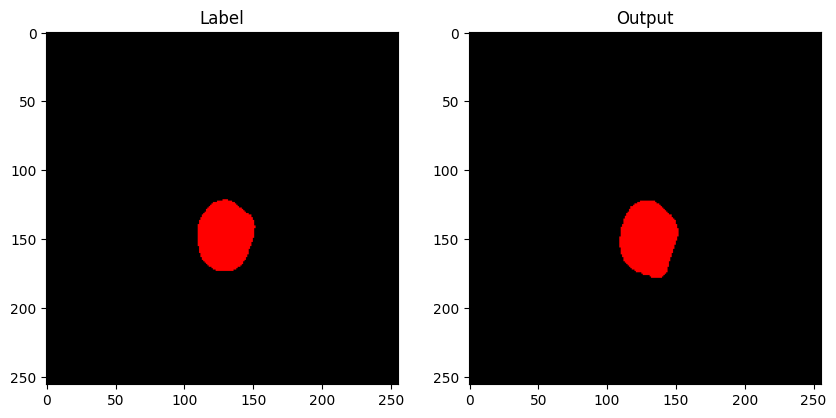

Epoch [11/125], Loss: 0.0667266336


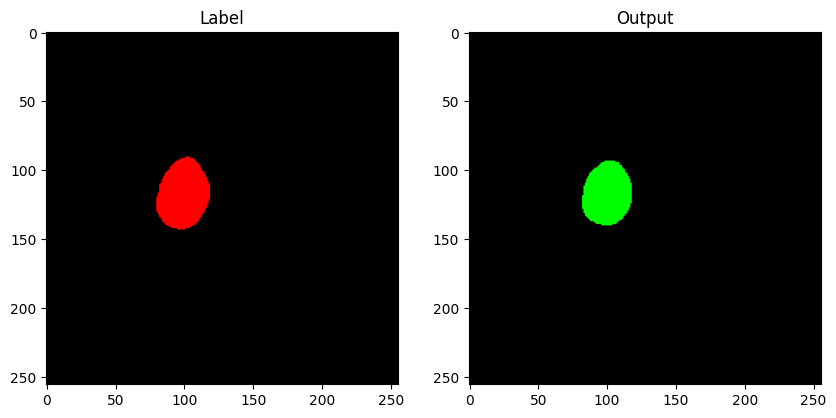

Epoch [12/125], Loss: 0.0597946028
Save new model


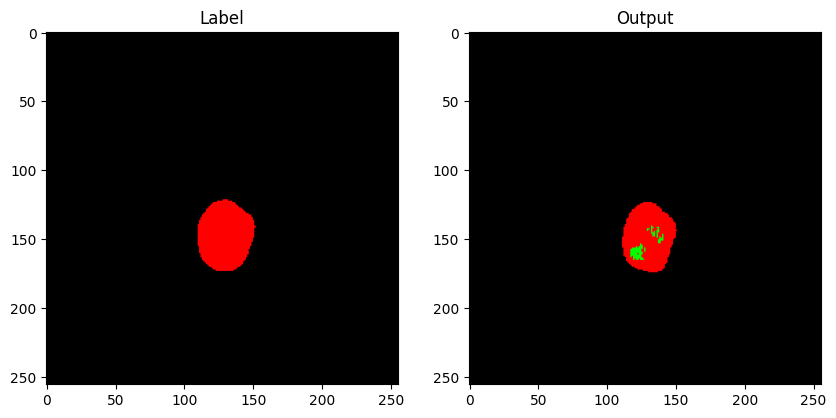

Epoch [13/125], Loss: 0.0708797935


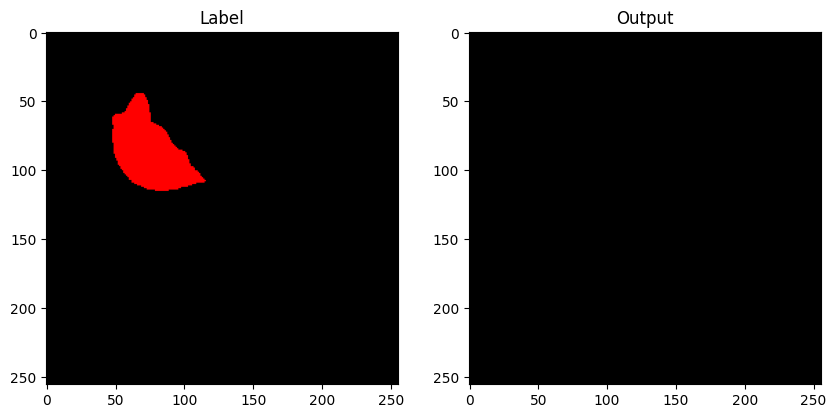

Epoch [14/125], Loss: 0.0601934437


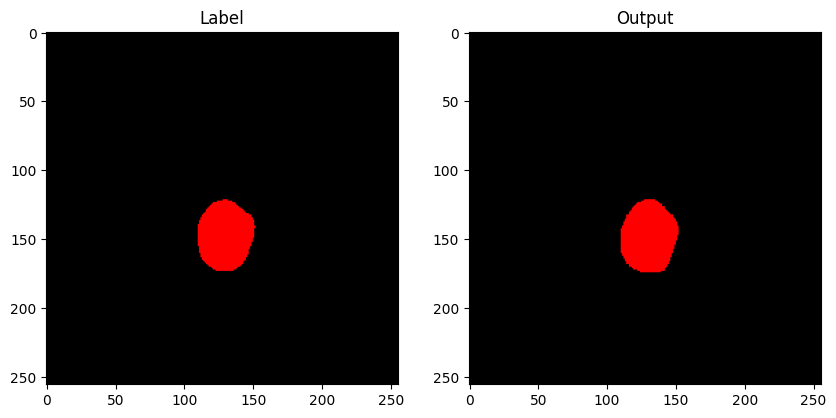

Epoch [15/125], Loss: 0.0529699010
Save new model


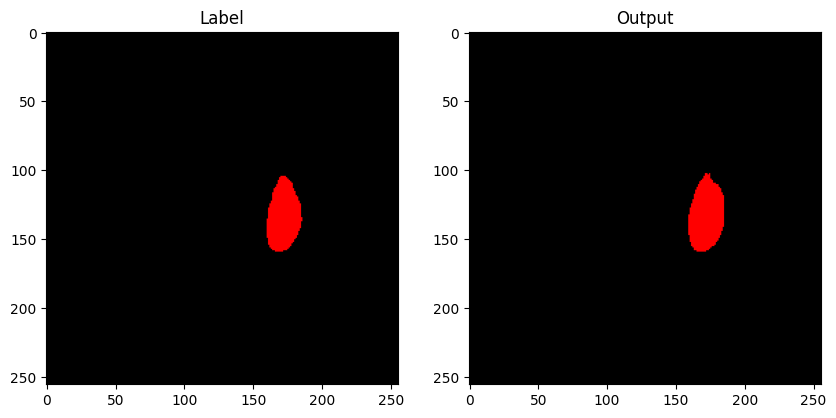

Epoch [16/125], Loss: 0.0545859228


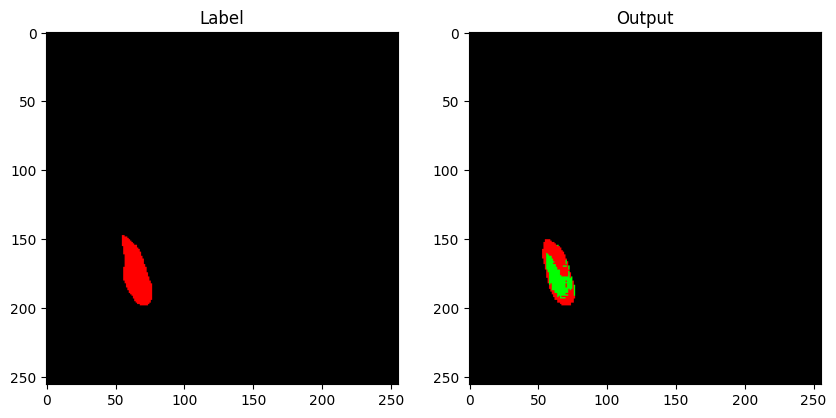

Epoch [17/125], Loss: 0.0564963905


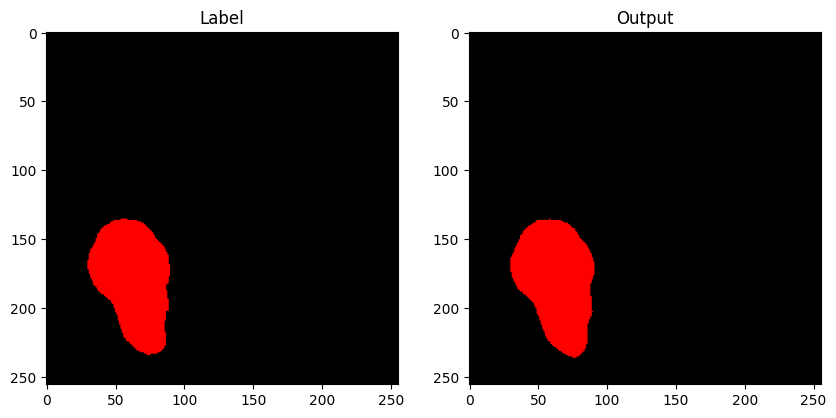

Epoch [18/125], Loss: 0.0520506276
Save new model


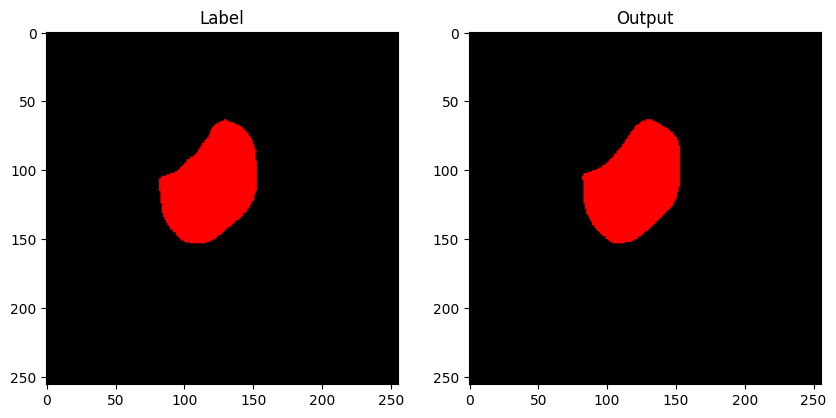

Epoch [19/125], Loss: 0.0521870899


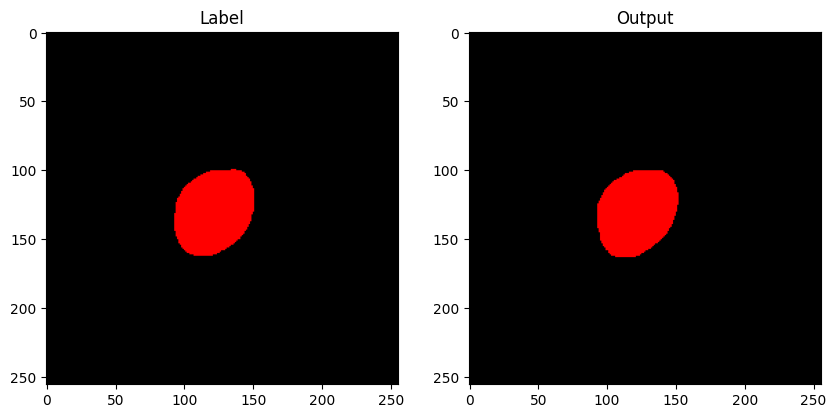

Epoch [20/125], Loss: 0.0676966959


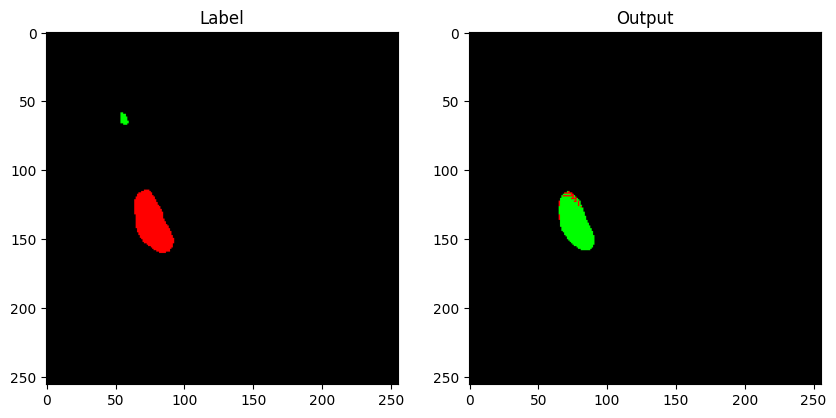

Epoch [21/125], Loss: 0.0599520881


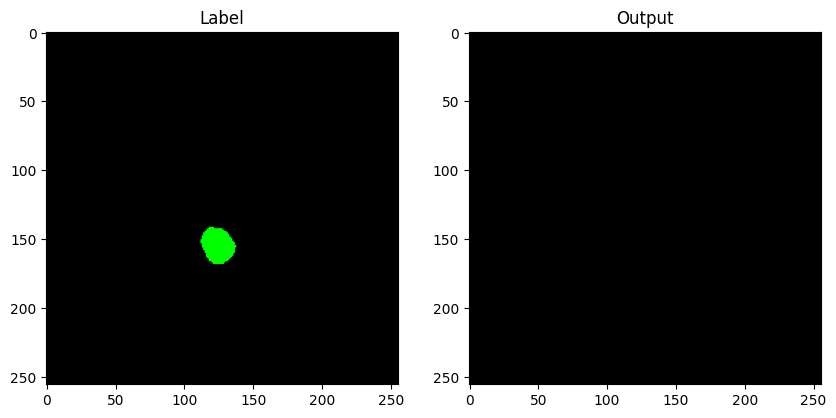

Epoch [22/125], Loss: 0.0514507781
Save new model


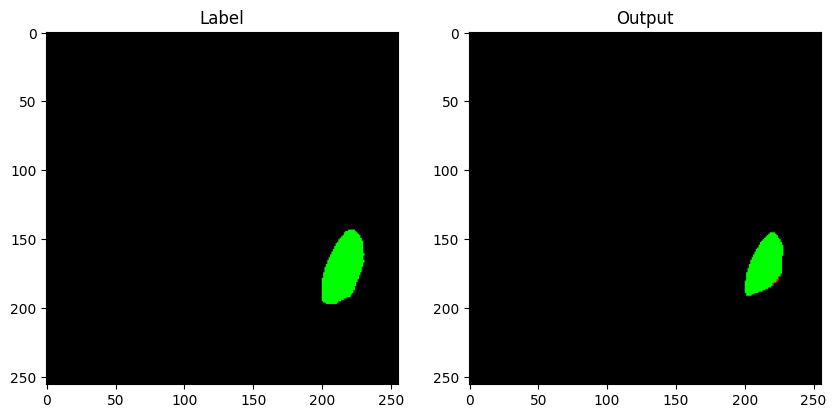

Epoch [23/125], Loss: 0.0528366275


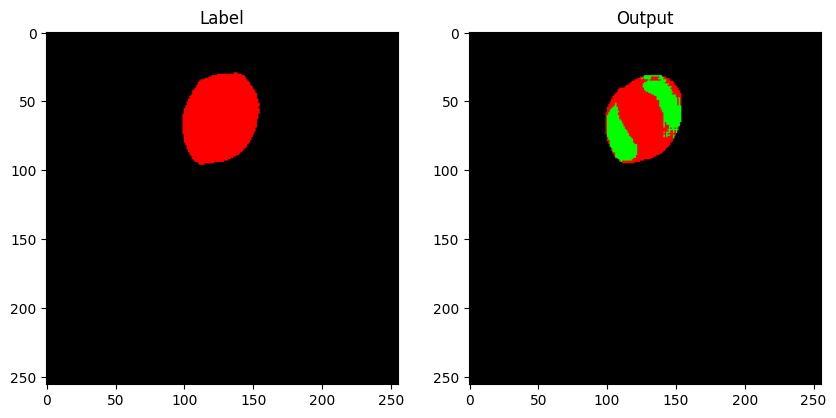

Epoch [24/125], Loss: 0.0528599408


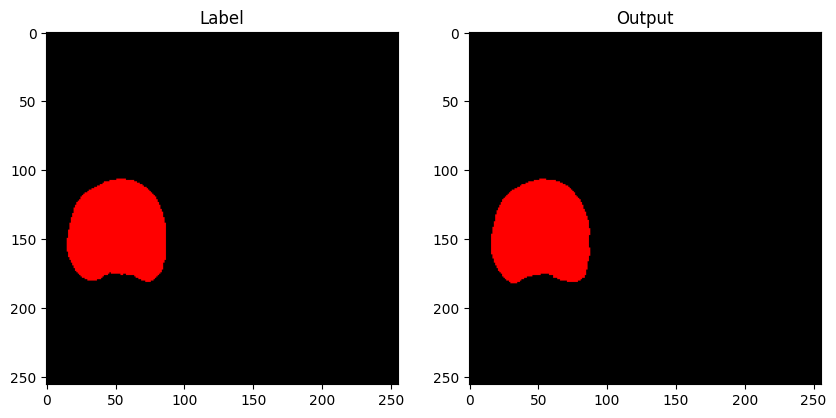

Epoch [25/125], Loss: 0.0584628789


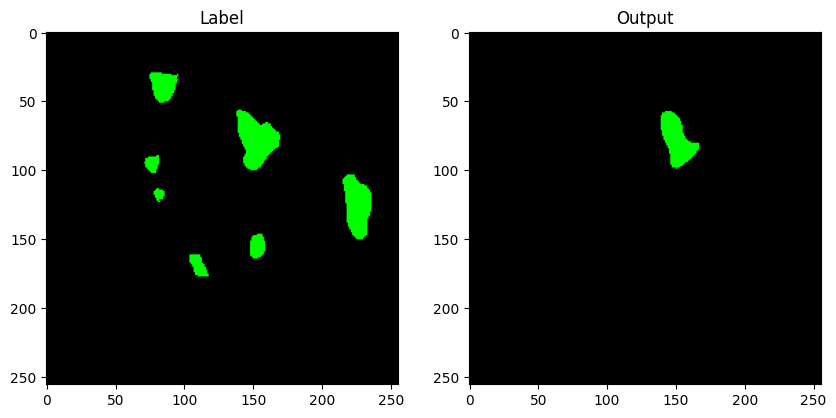

Epoch [26/125], Loss: 0.0590549422


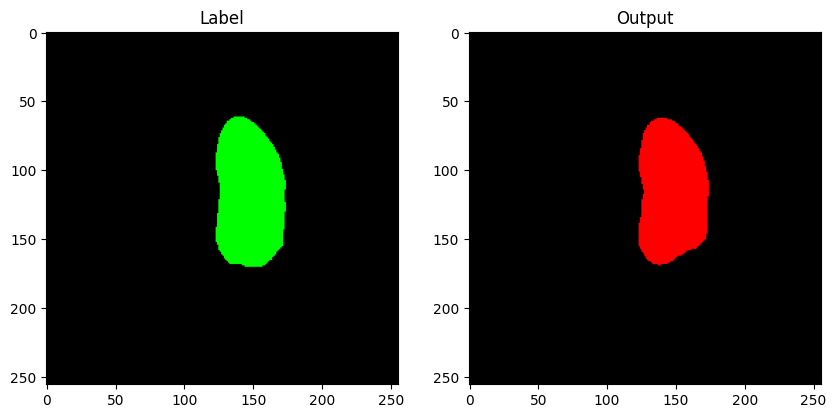

Epoch [27/125], Loss: 0.0511643904
Save new model


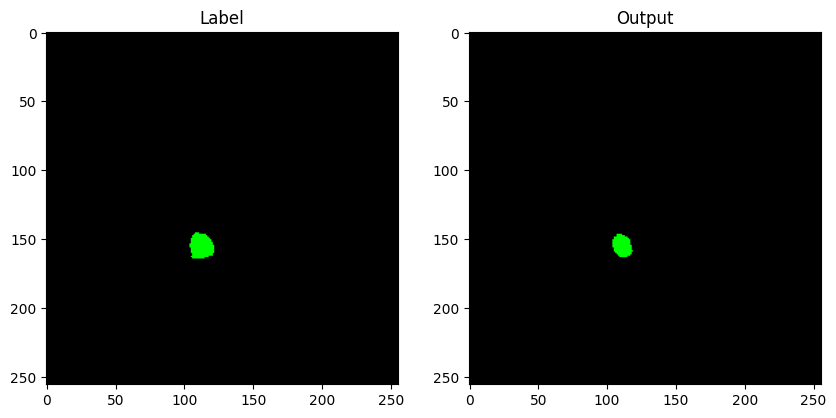

Epoch [28/125], Loss: 0.0547556813


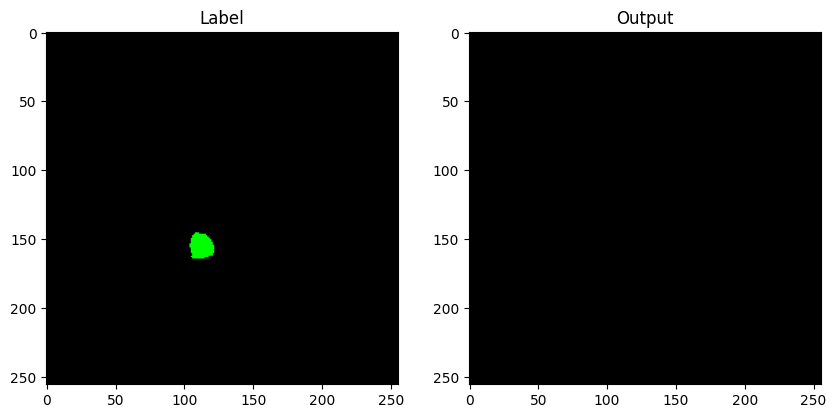

Epoch [29/125], Loss: 0.0639681464


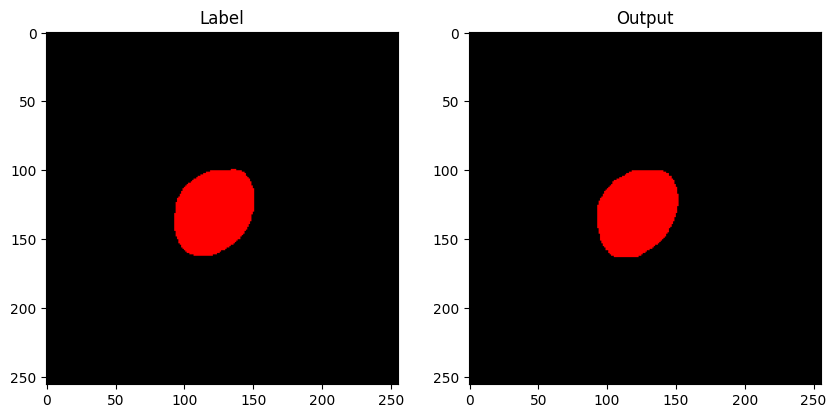

Epoch [30/125], Loss: 0.0576021231


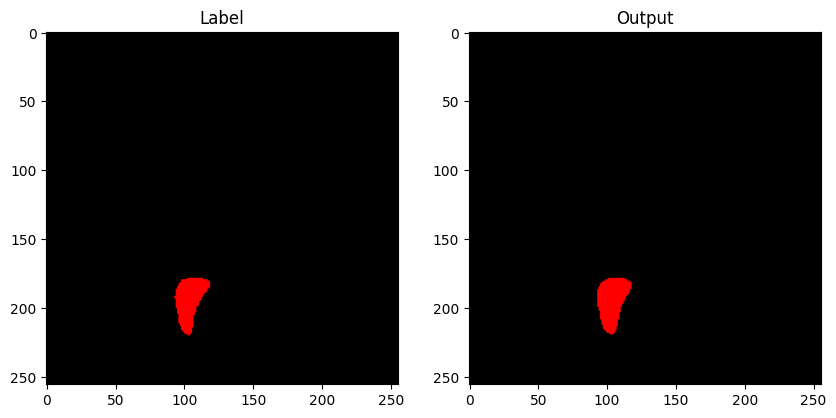

Epoch [31/125], Loss: 0.0568841718


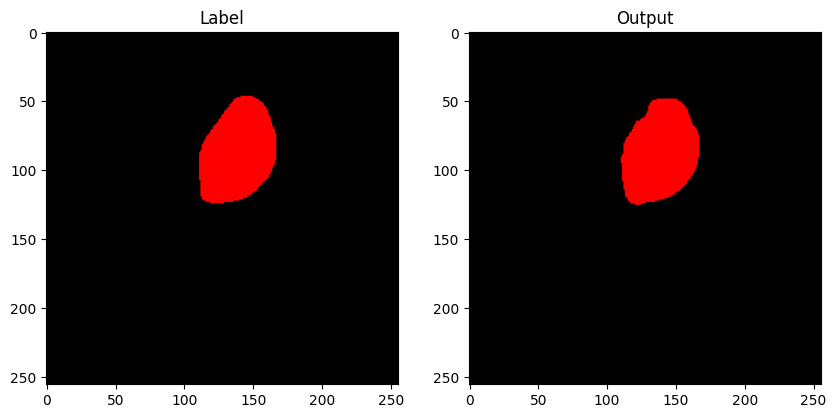

Epoch [32/125], Loss: 0.0555066979


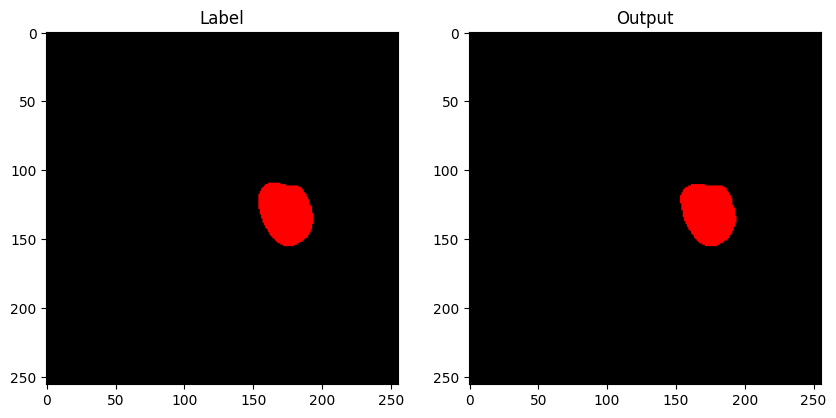

Epoch [33/125], Loss: 0.0645133975


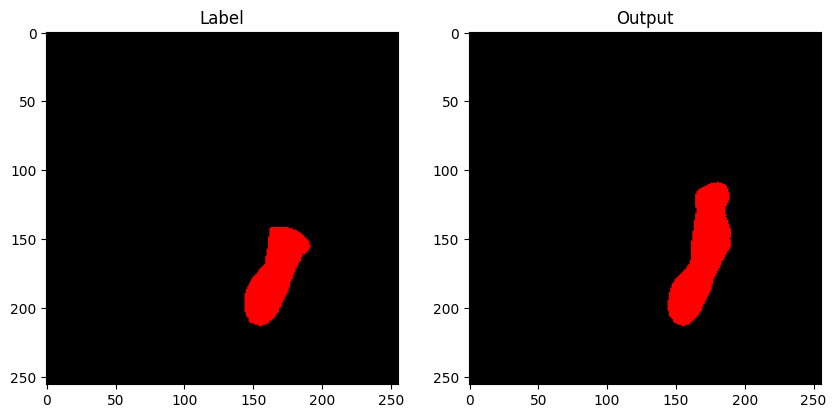

Epoch [34/125], Loss: 0.0637793495


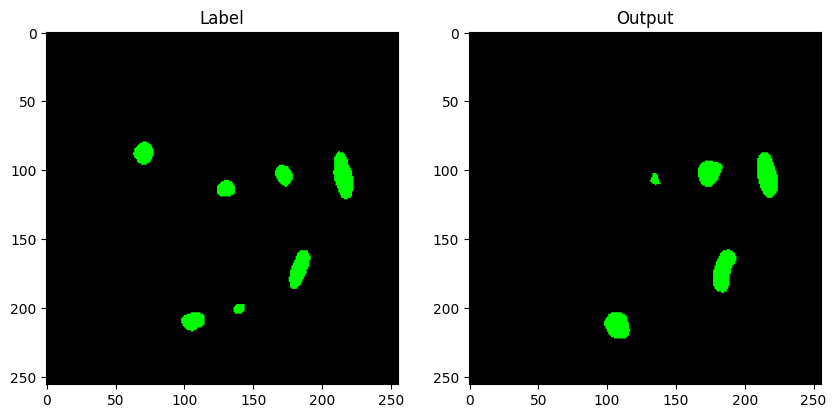

Epoch [35/125], Loss: 0.0581354065


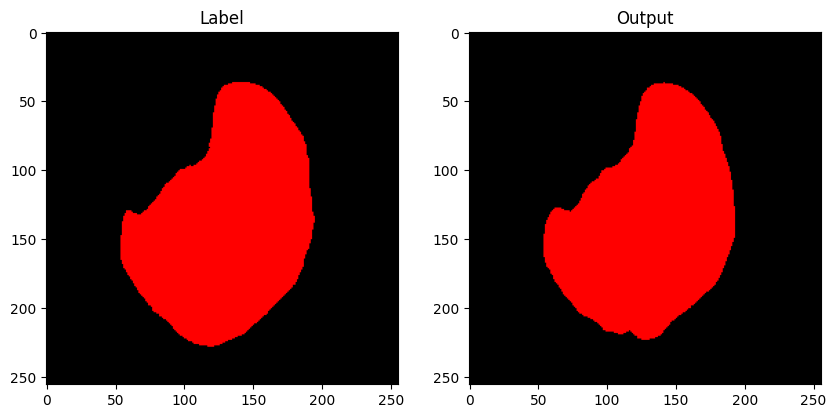

Epoch [36/125], Loss: 0.0514643038


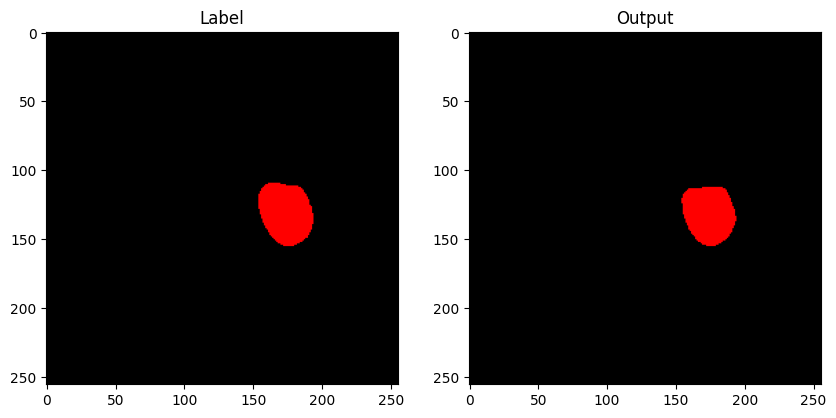

Epoch [37/125], Loss: 0.0615479690


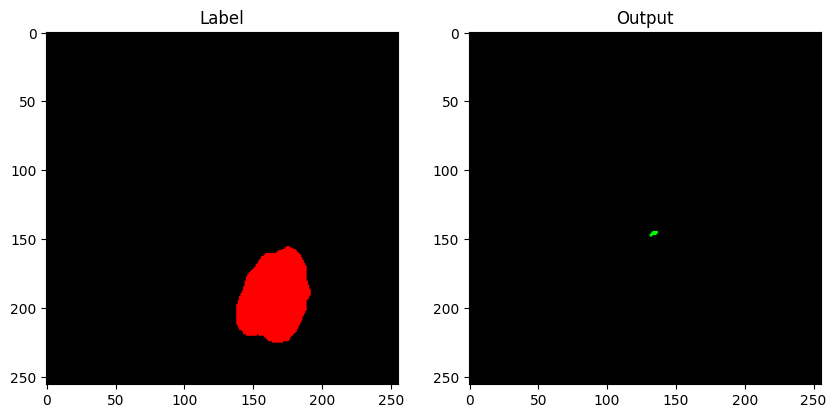

Epoch [38/125], Loss: 0.0576828995


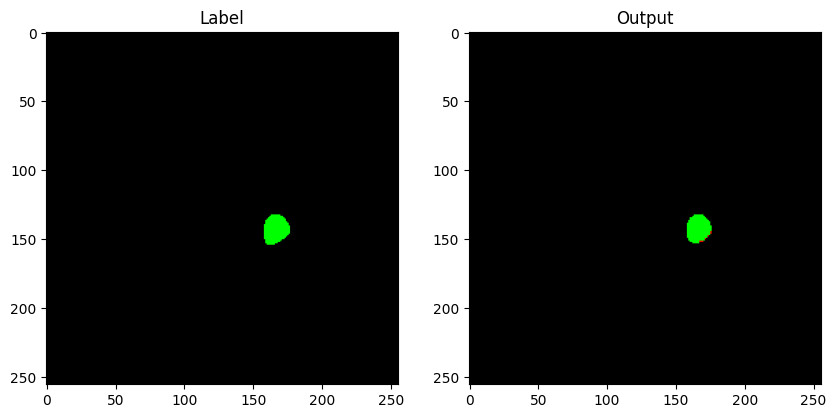

Epoch [39/125], Loss: 0.0652940089


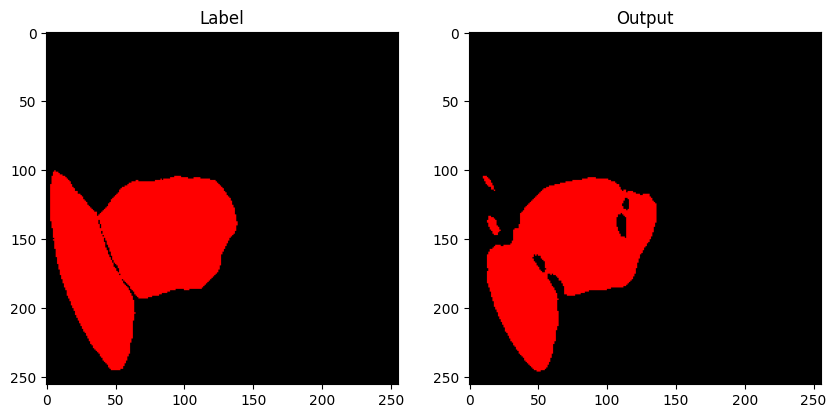

Epoch [40/125], Loss: 0.0612279112


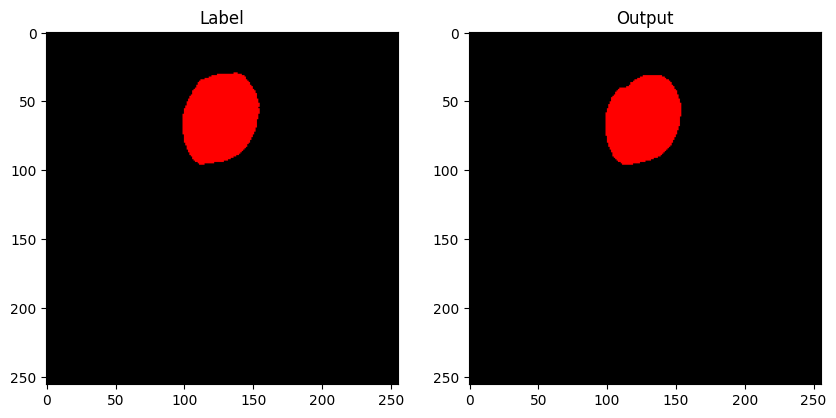

Epoch [41/125], Loss: 0.0592701974


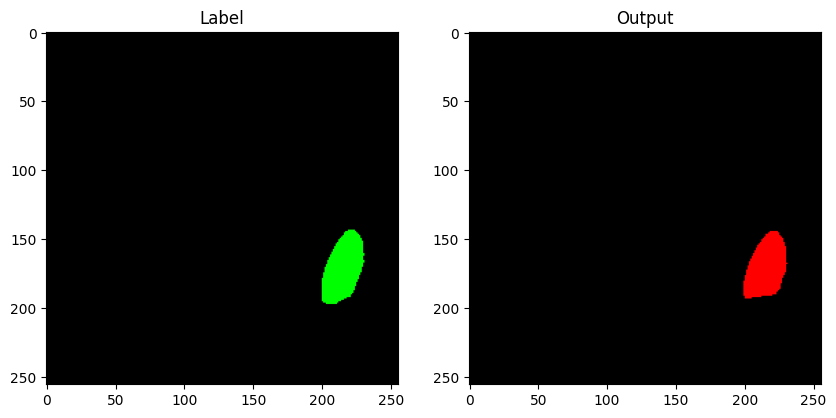

Epoch [42/125], Loss: 0.0625711960


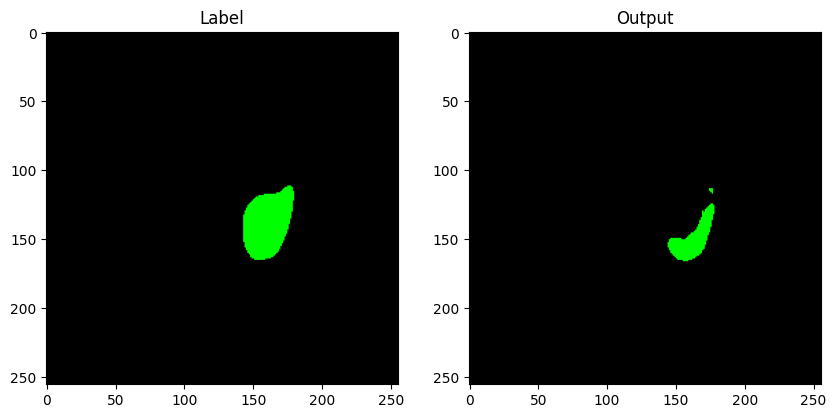

Epoch [43/125], Loss: 0.0617089805


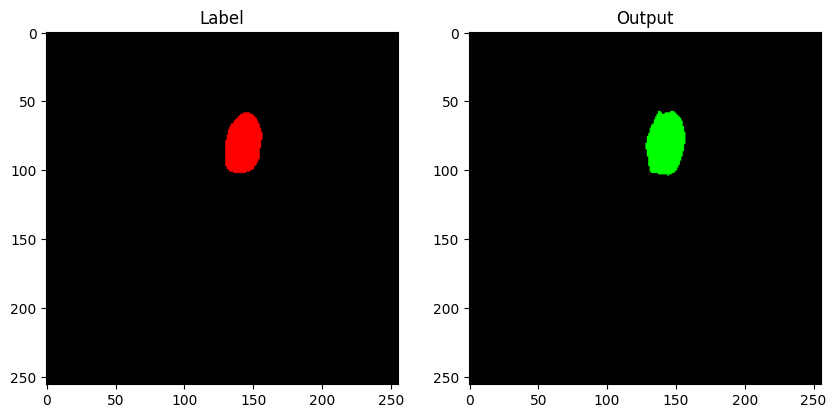

Epoch [44/125], Loss: 0.0668025895


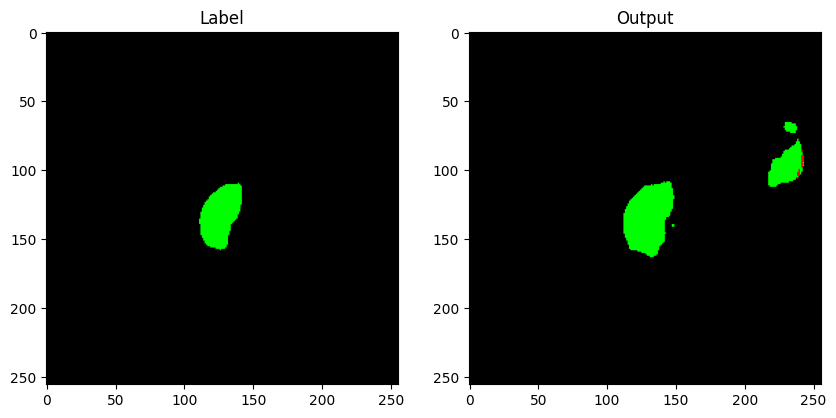

Epoch [45/125], Loss: 0.0618616925


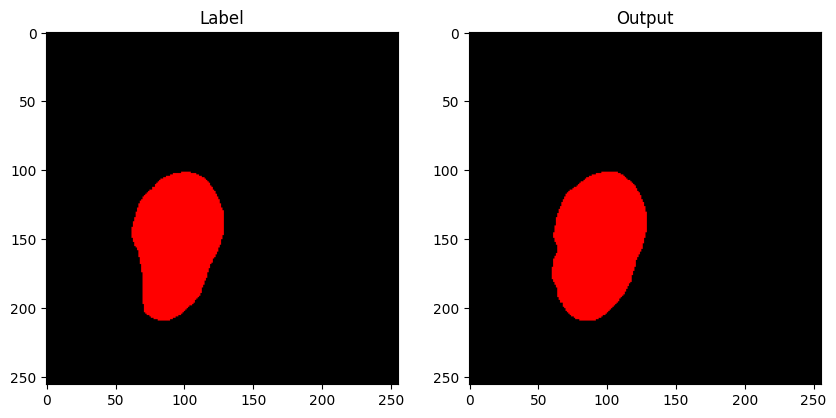

Epoch [46/125], Loss: 0.0641632038


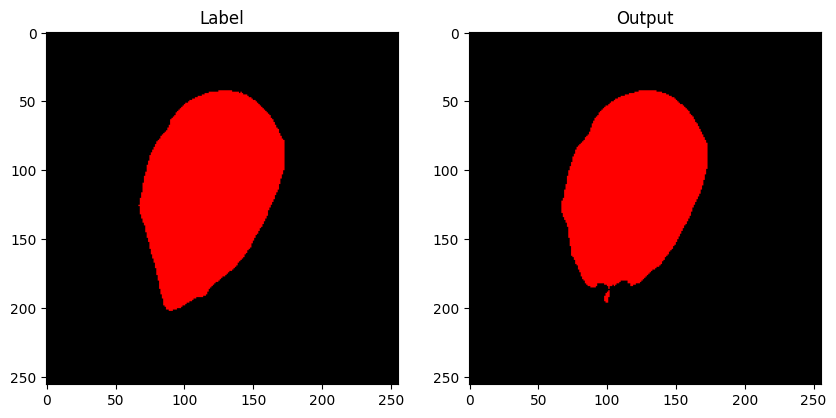

Epoch [47/125], Loss: 0.0694953579


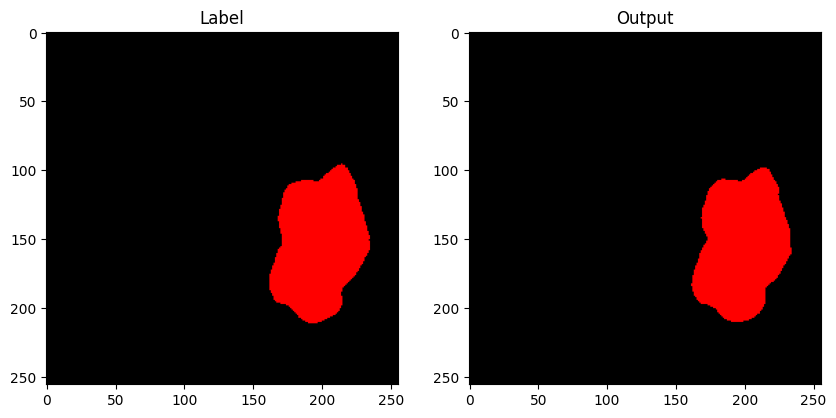

Epoch [48/125], Loss: 0.0612413380


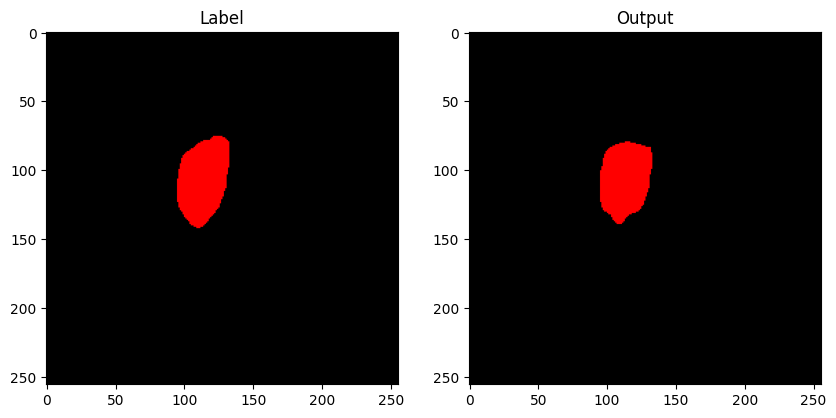

Epoch [49/125], Loss: 0.0658744825


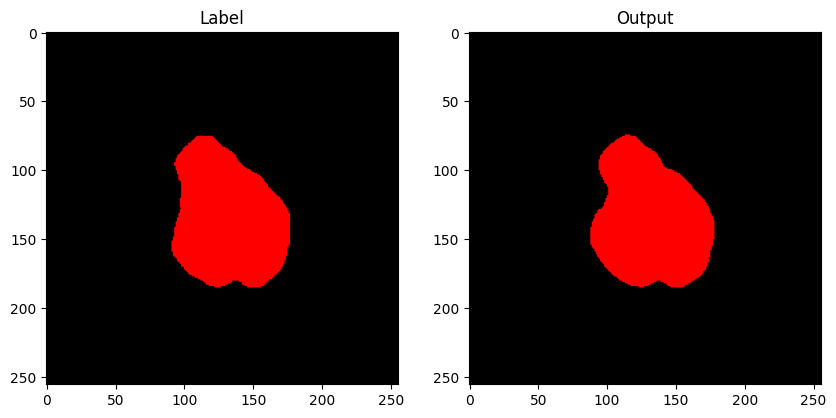

Epoch [50/125], Loss: 0.0792955215


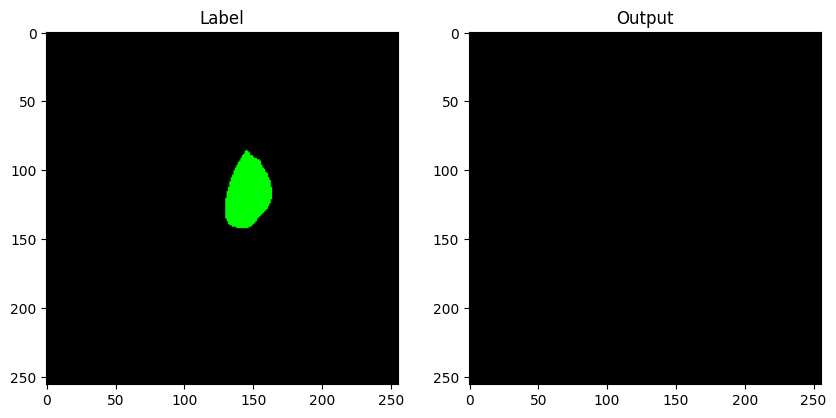

Epoch [51/125], Loss: 0.0631657713


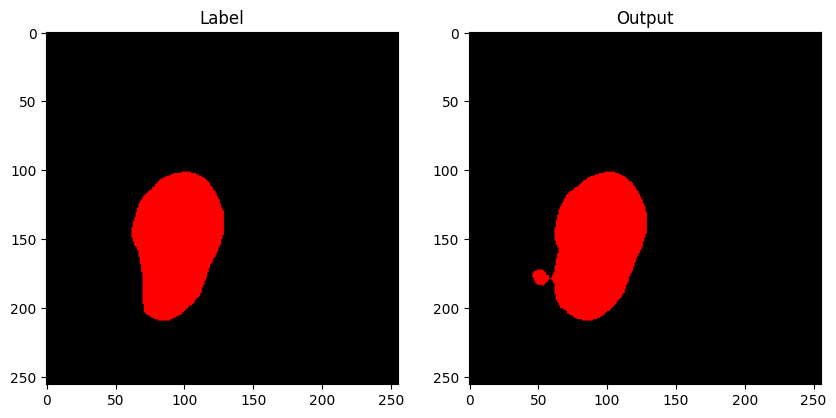

Epoch [52/125], Loss: 0.0615320944


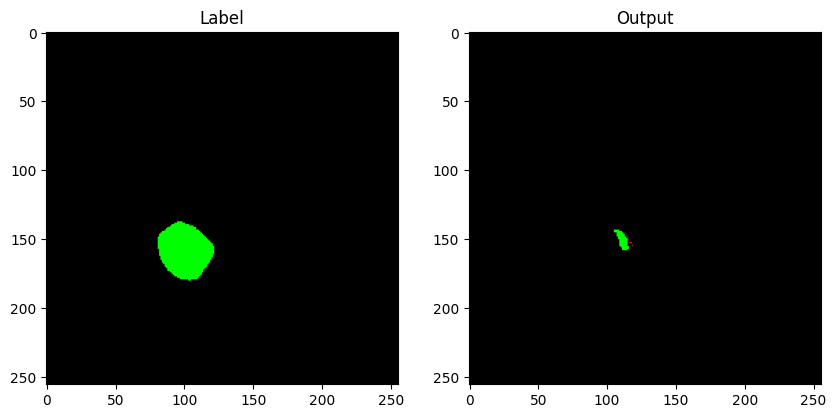

Epoch [53/125], Loss: 0.0624560487


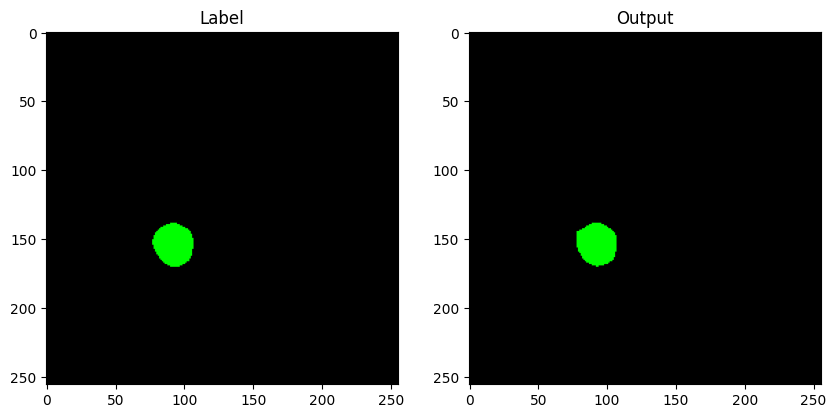

Epoch [54/125], Loss: 0.0605823895


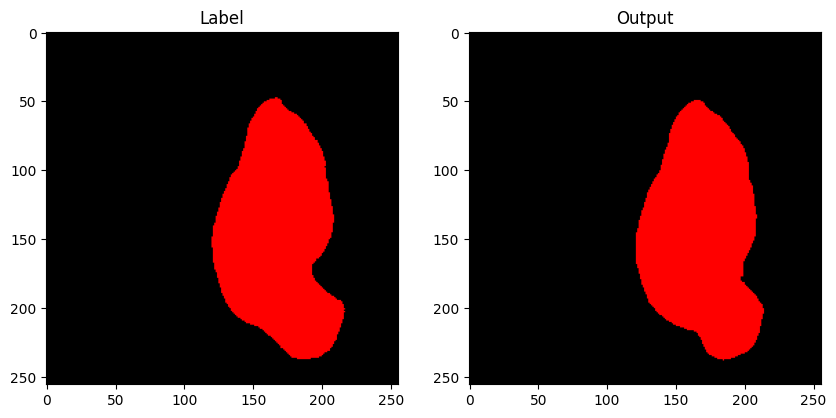

Epoch [55/125], Loss: 0.0639339844


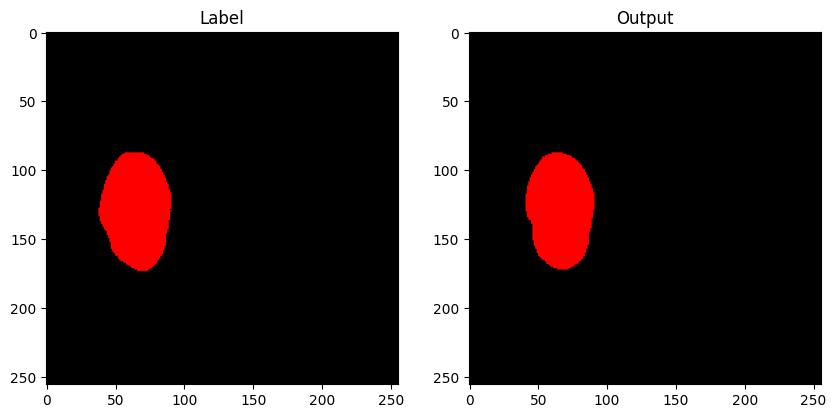

Epoch [56/125], Loss: 0.0667297098


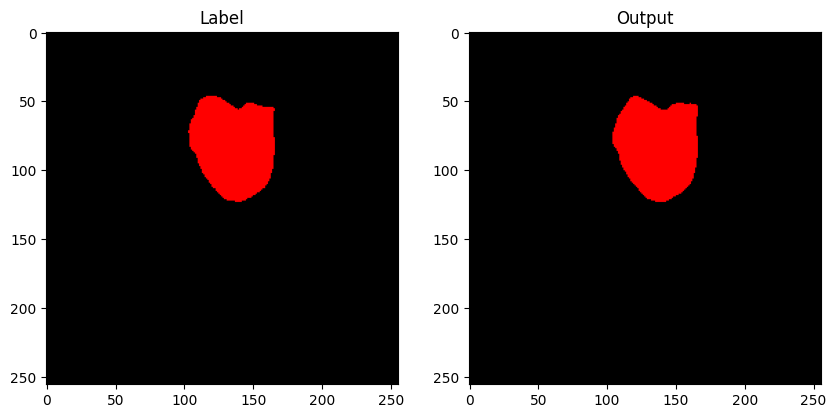

Epoch [57/125], Loss: 0.0628949964


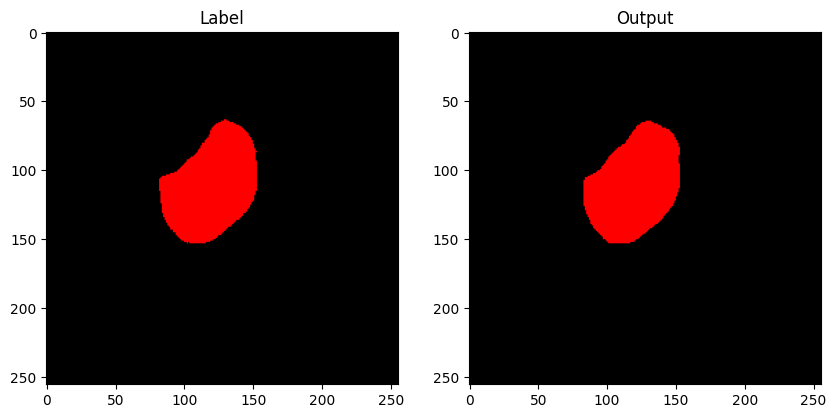

Epoch [58/125], Loss: 0.0701459575


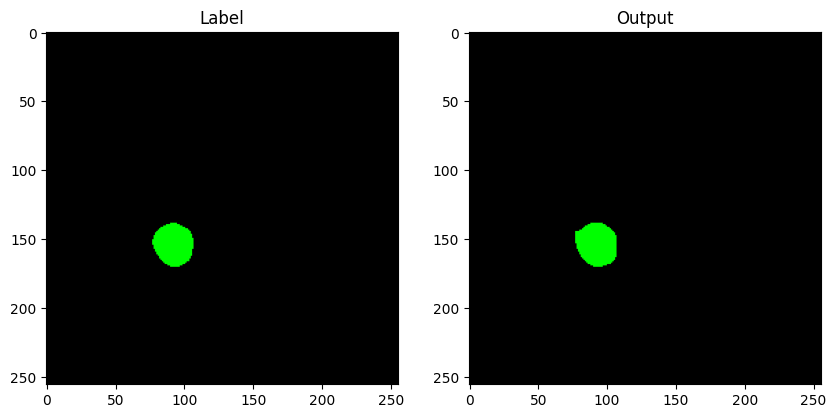

Epoch [59/125], Loss: 0.0763553947


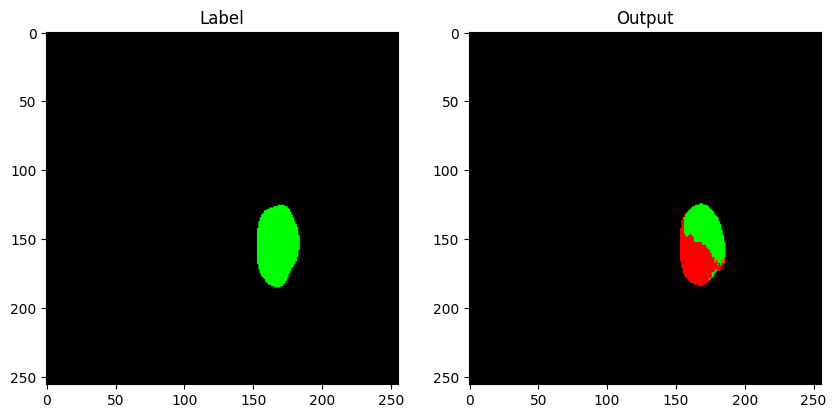

Epoch [60/125], Loss: 0.0645043737


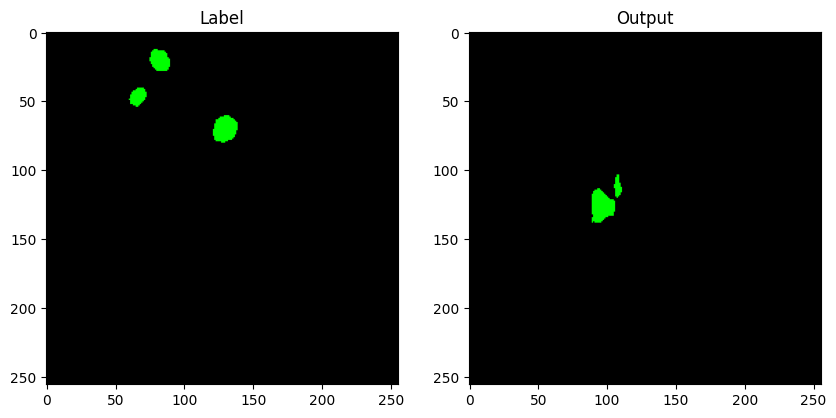

Epoch [61/125], Loss: 0.0597257113


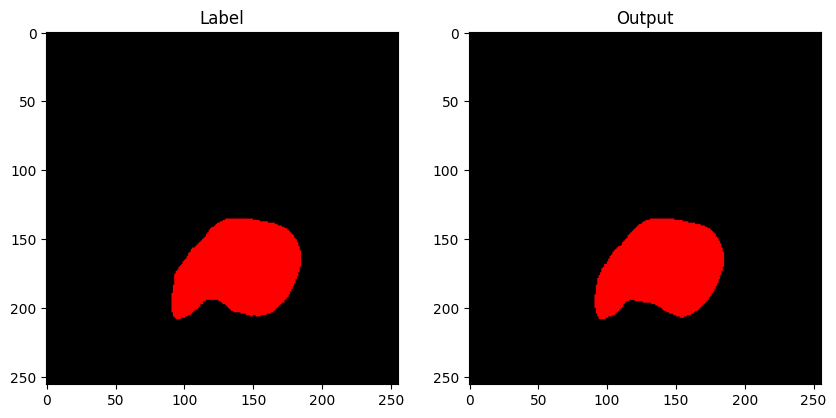

Epoch [62/125], Loss: 0.0676239874


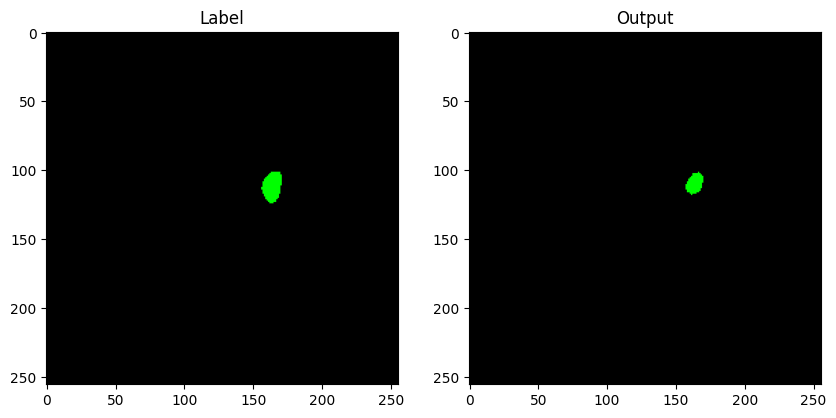

Epoch [63/125], Loss: 0.0614372319


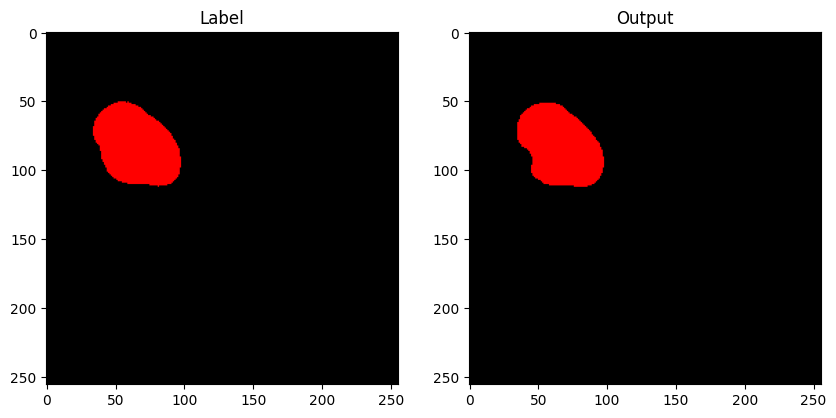

Epoch [64/125], Loss: 0.0649104555


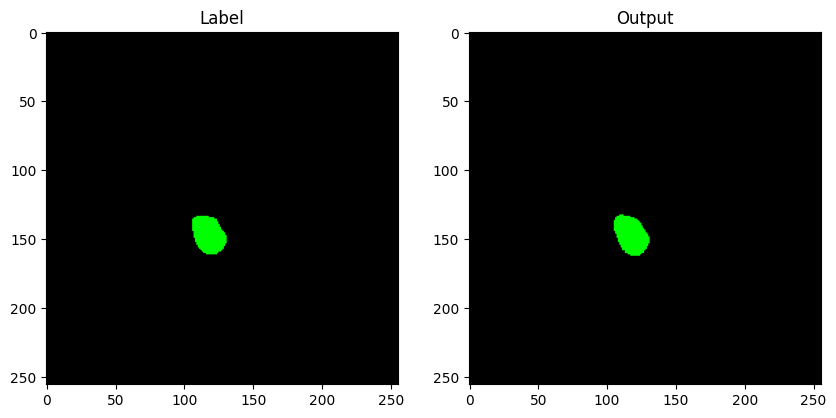

Epoch [65/125], Loss: 0.0654745440


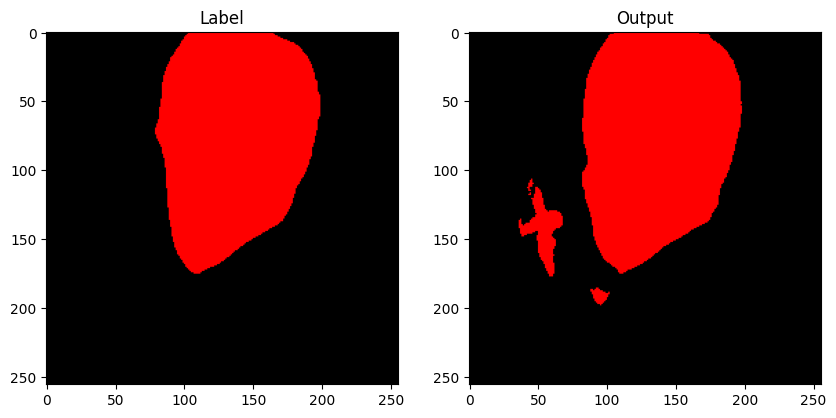

Epoch [66/125], Loss: 0.0551849841


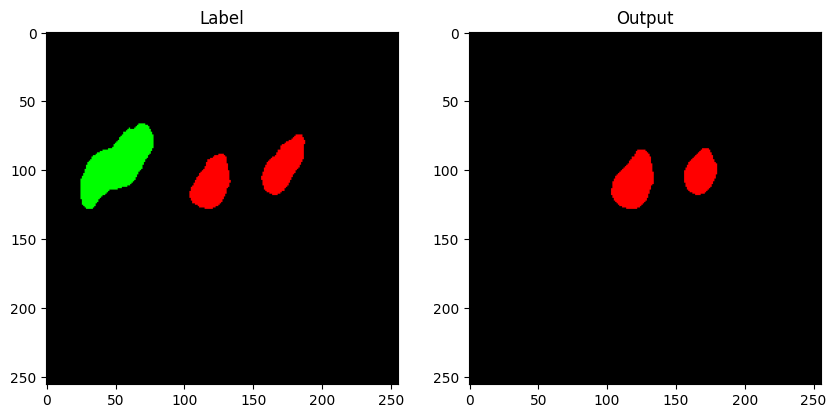

Epoch [67/125], Loss: 0.0611591406


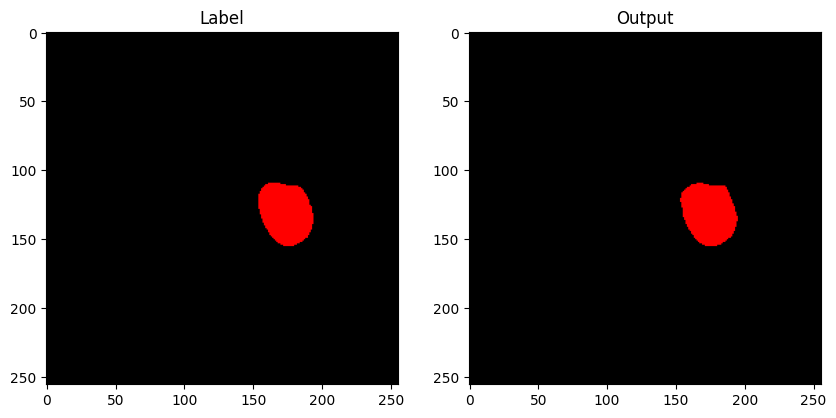

Epoch [68/125], Loss: 0.0686209827


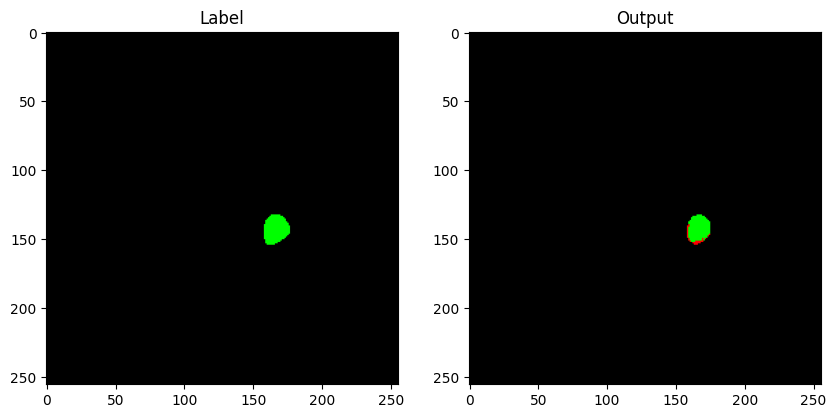

Epoch [69/125], Loss: 0.0594704749


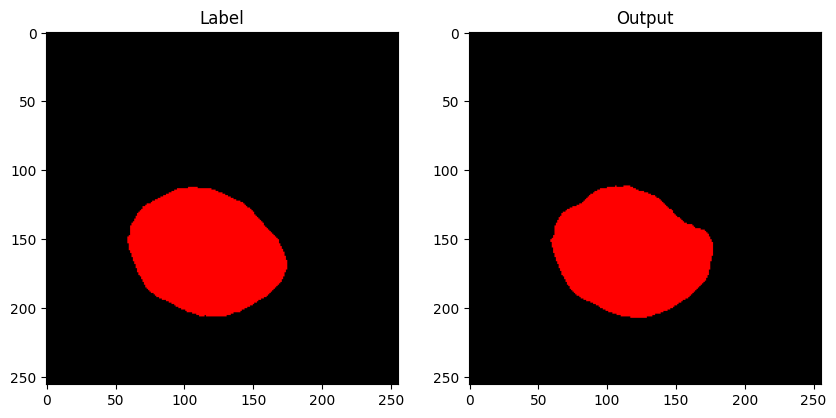

Epoch [70/125], Loss: 0.0608887100


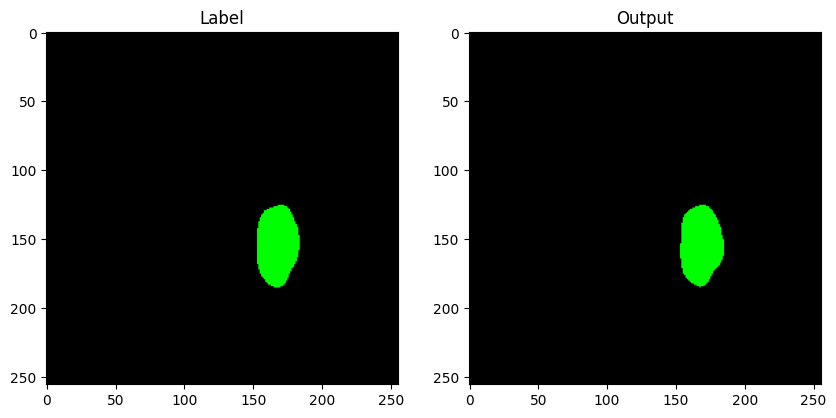

Epoch [71/125], Loss: 0.0600024033


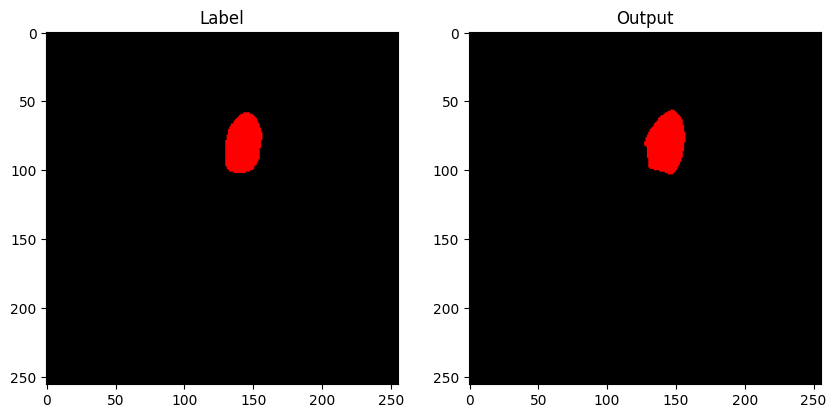

Epoch [72/125], Loss: 0.0637525513


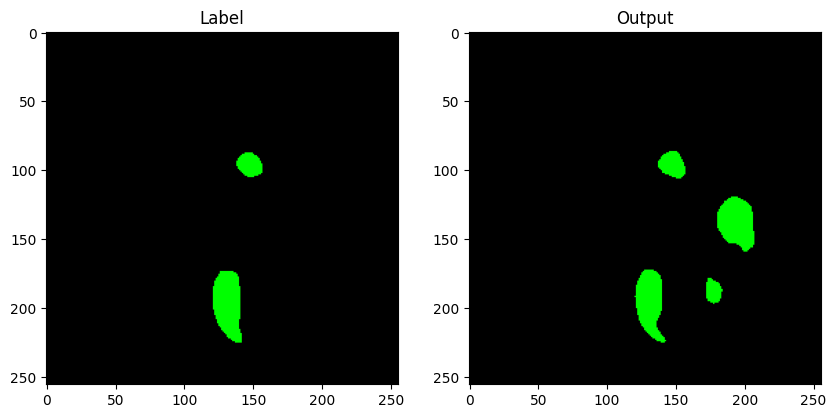

Epoch [73/125], Loss: 0.0707806567


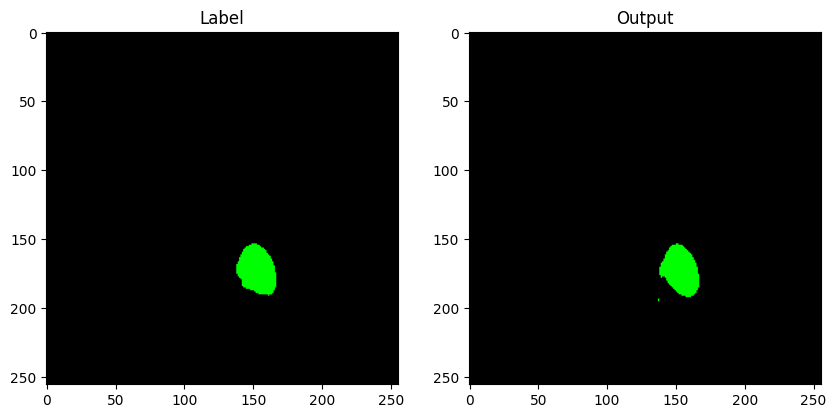

Epoch [74/125], Loss: 0.0823236078


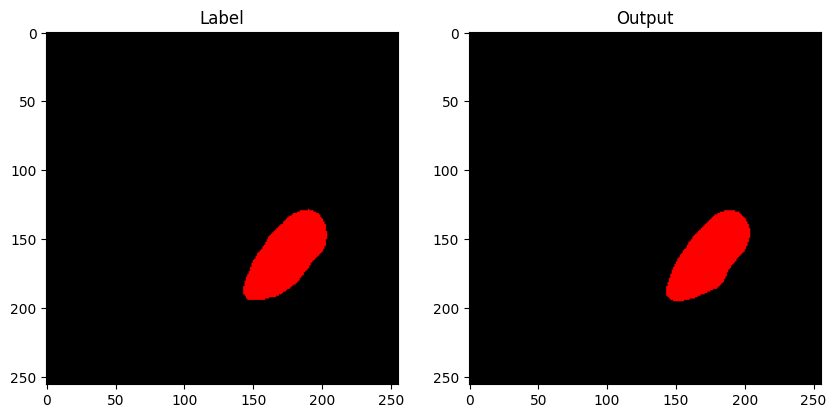

Epoch [75/125], Loss: 0.0648027560


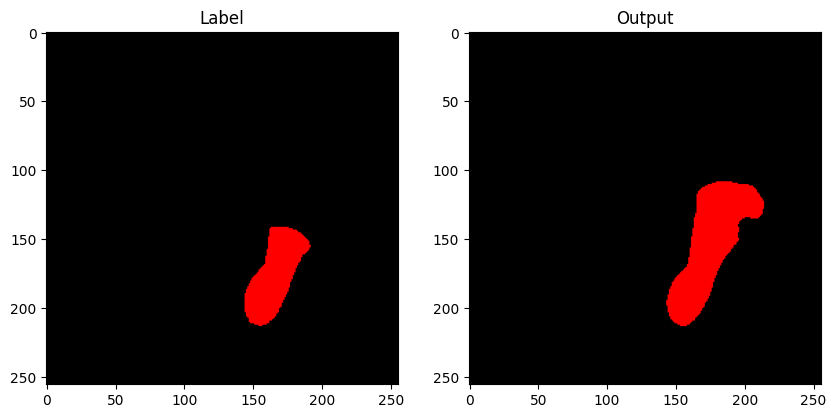

Epoch [76/125], Loss: 0.0564470103


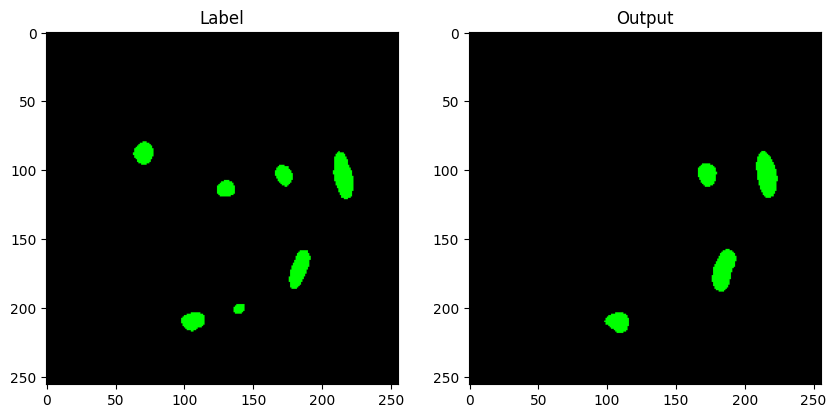

Epoch [77/125], Loss: 0.0723515067


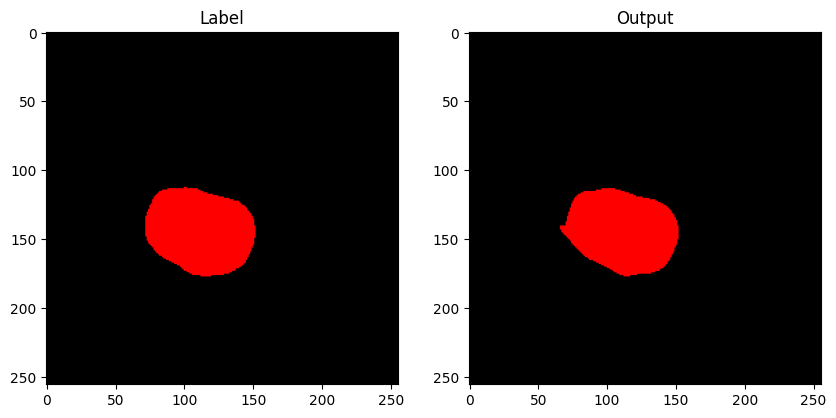

Epoch [78/125], Loss: 0.0652232541


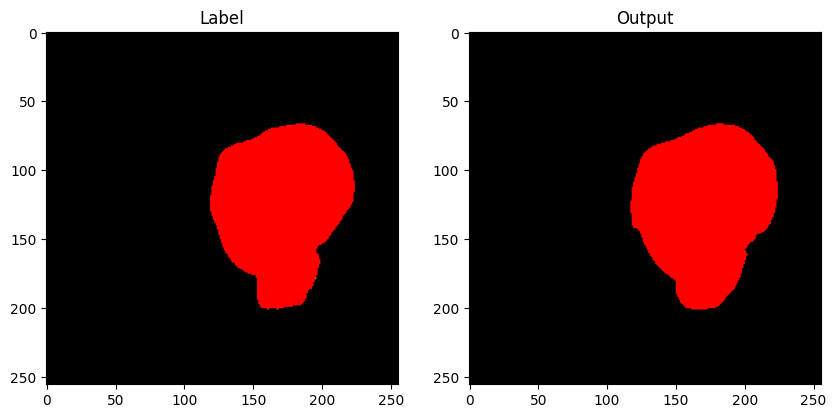

Epoch [79/125], Loss: 0.0736576625


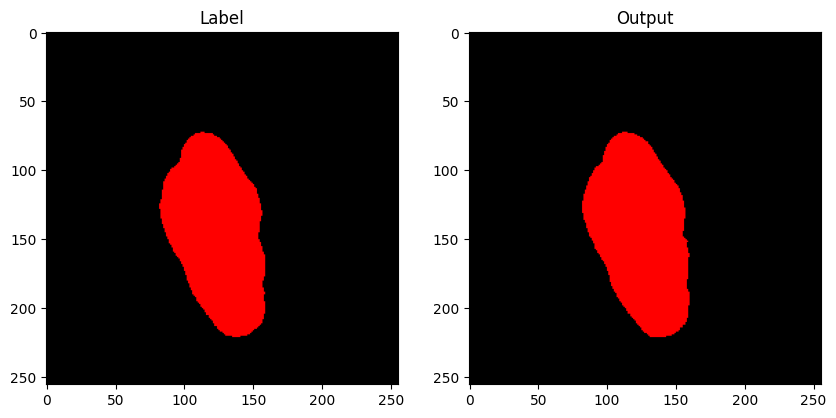

Epoch [80/125], Loss: 0.0550082416


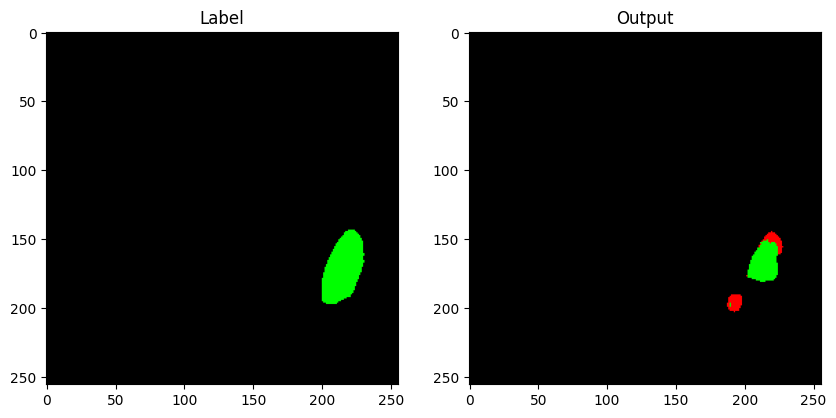

Epoch [81/125], Loss: 0.0613998597


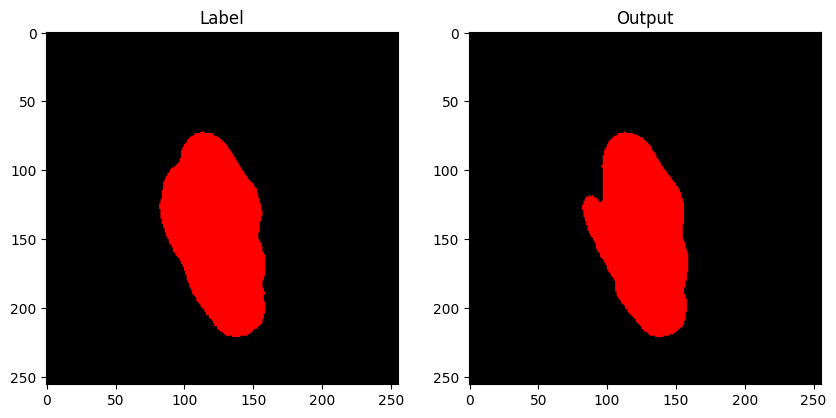

Epoch [82/125], Loss: 0.0827156366


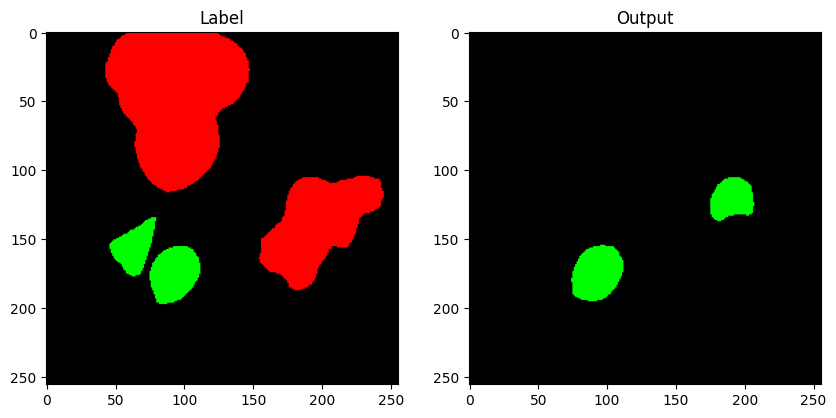

Epoch [83/125], Loss: 0.0569903805


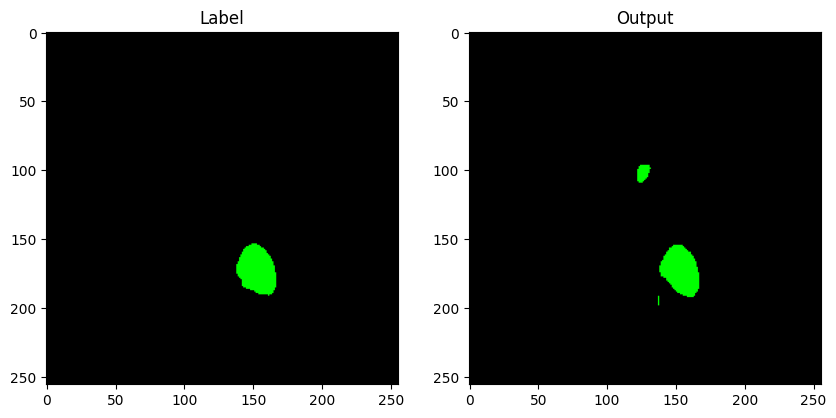

Epoch [84/125], Loss: 0.0652634397


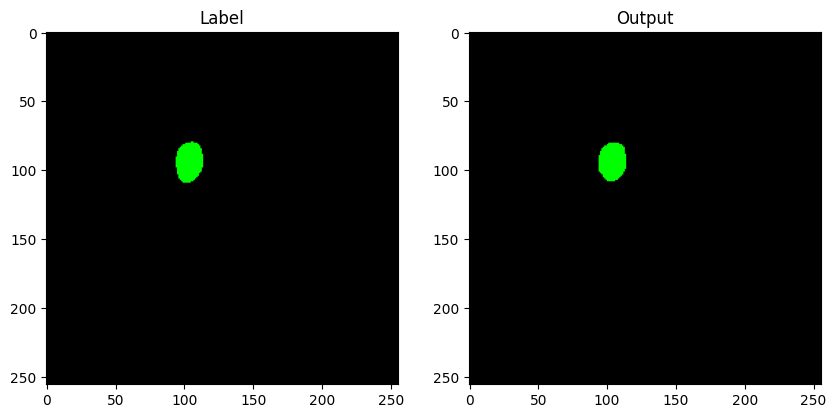

Epoch [85/125], Loss: 0.0653431447


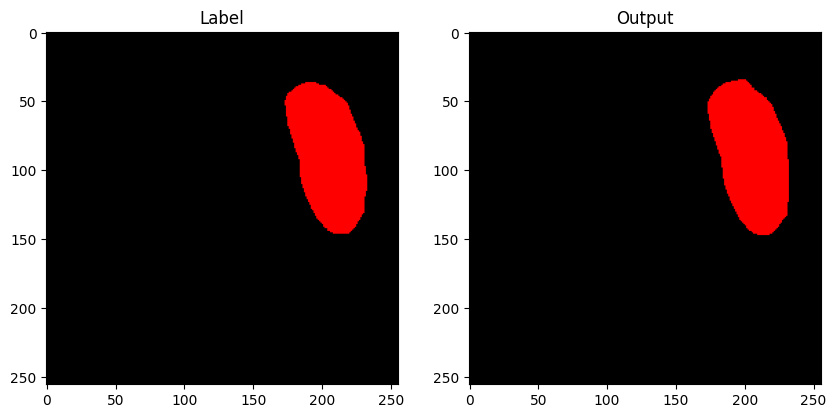

Epoch [86/125], Loss: 0.0654119892


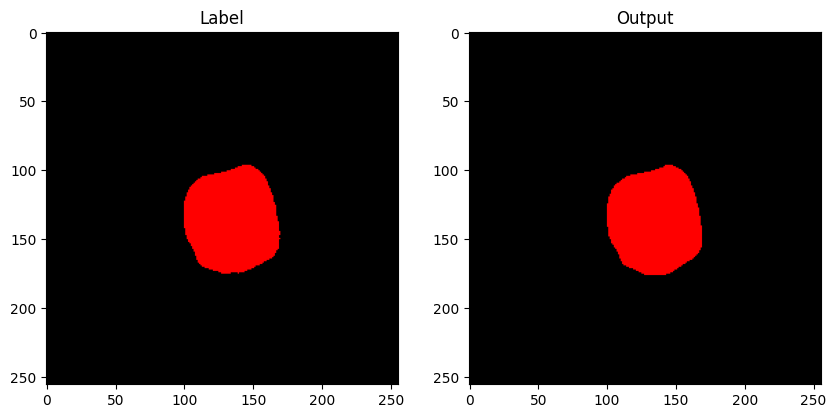

Epoch [87/125], Loss: 0.0671301212


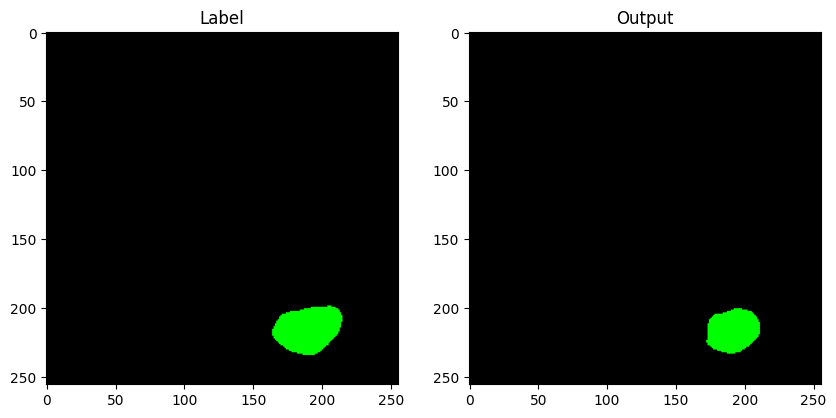

Epoch [88/125], Loss: 0.0705534569


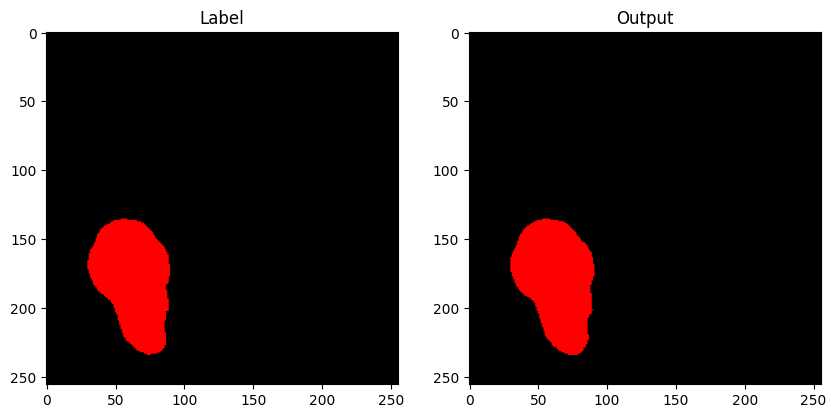

Epoch [89/125], Loss: 0.0713434503


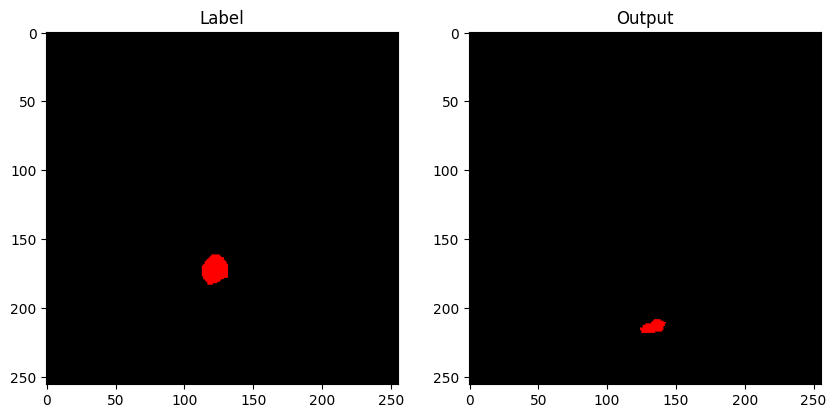

Epoch [90/125], Loss: 0.0727962370


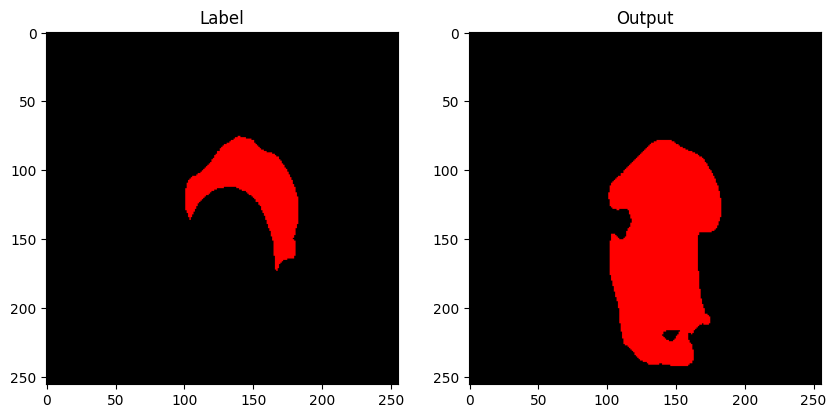

Epoch [91/125], Loss: 0.0658011858


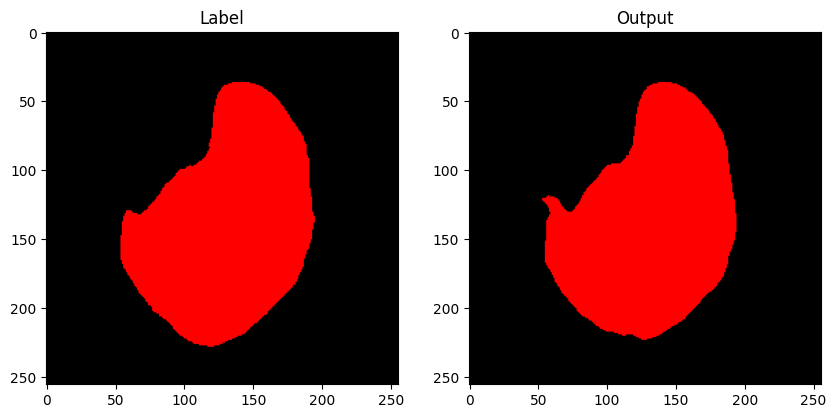

Epoch [92/125], Loss: 0.0742830633


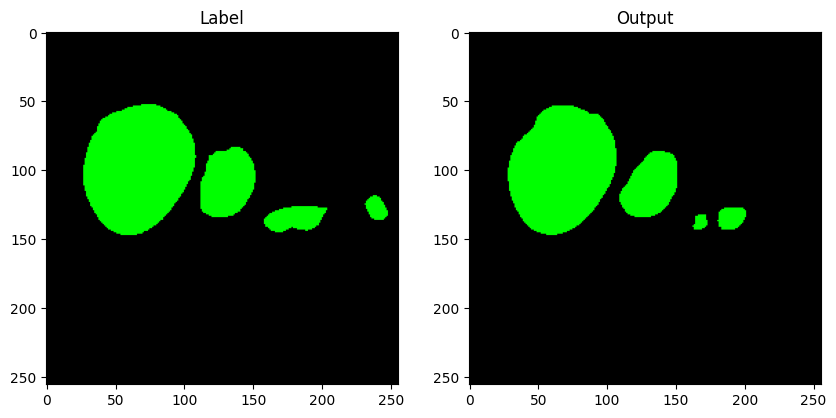

Epoch [93/125], Loss: 0.0730745680


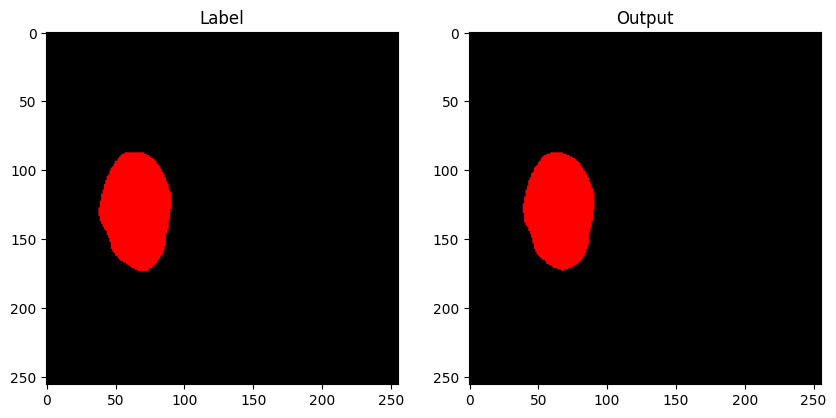

Epoch [94/125], Loss: 0.0784026366


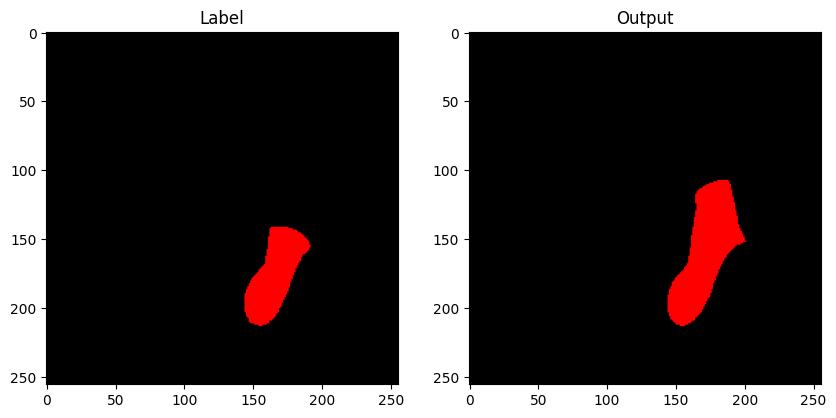

Epoch [95/125], Loss: 0.0731547469


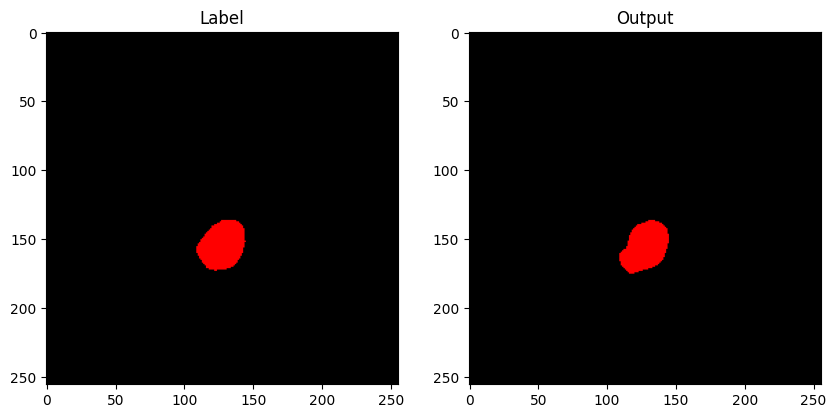

Epoch [96/125], Loss: 0.0717353175


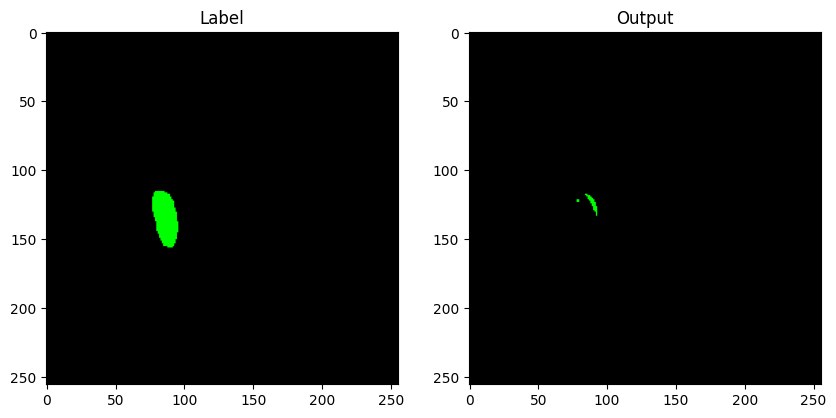

Epoch [97/125], Loss: 0.0643832444


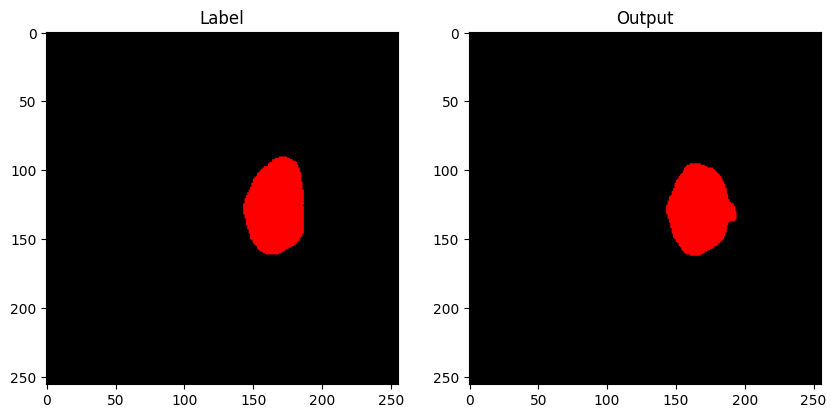

Epoch [98/125], Loss: 0.0750402278


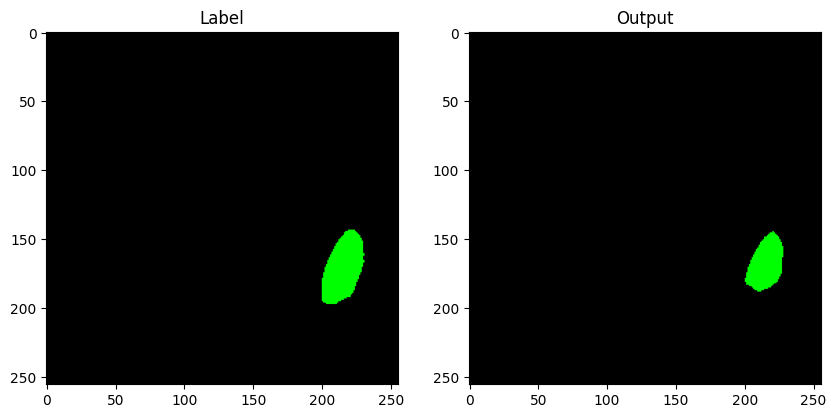

Epoch [99/125], Loss: 0.0766557260


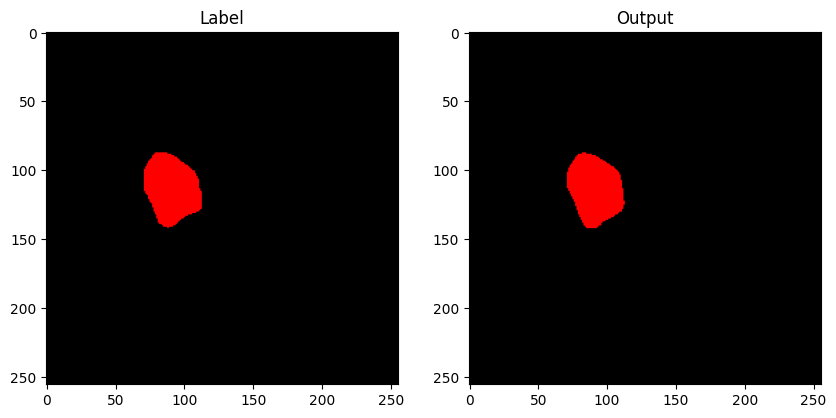

Epoch [100/125], Loss: 0.0705093254


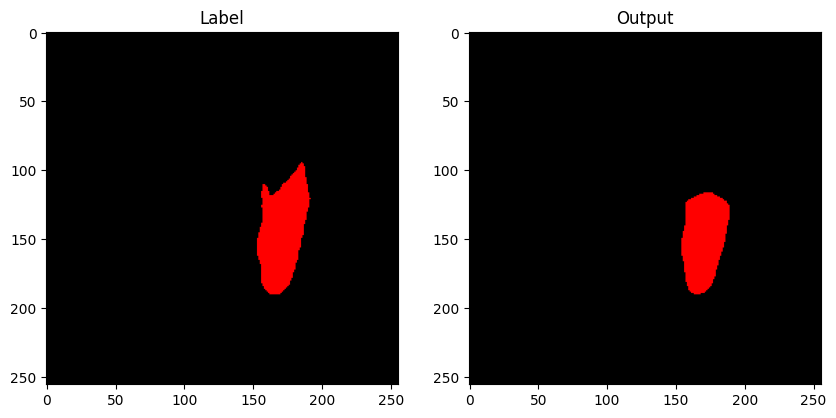

Epoch [101/125], Loss: 0.0723774377


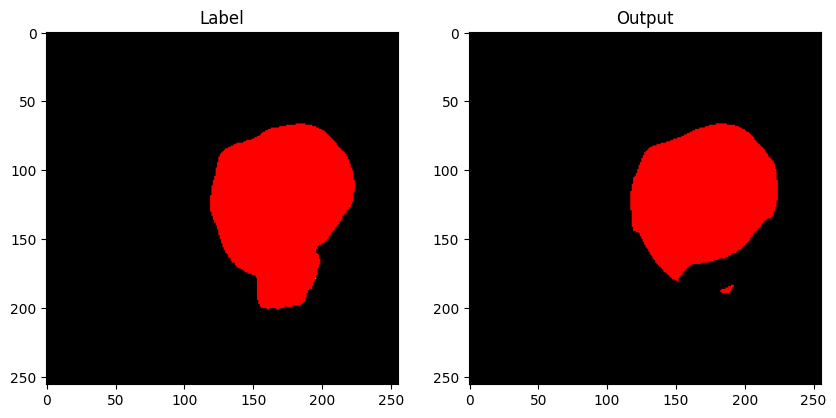

Epoch [102/125], Loss: 0.0921289547


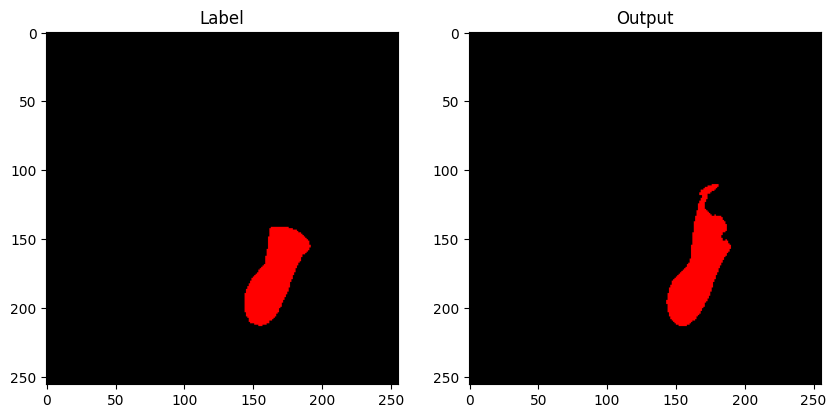

Epoch [103/125], Loss: 0.0616774632


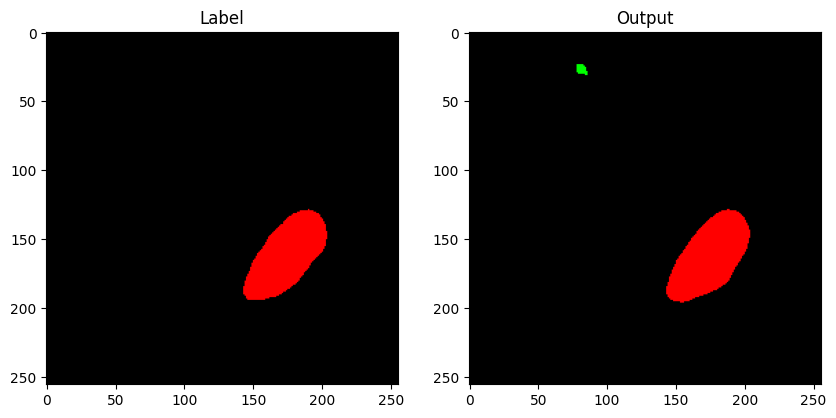

Epoch [104/125], Loss: 0.0739499550


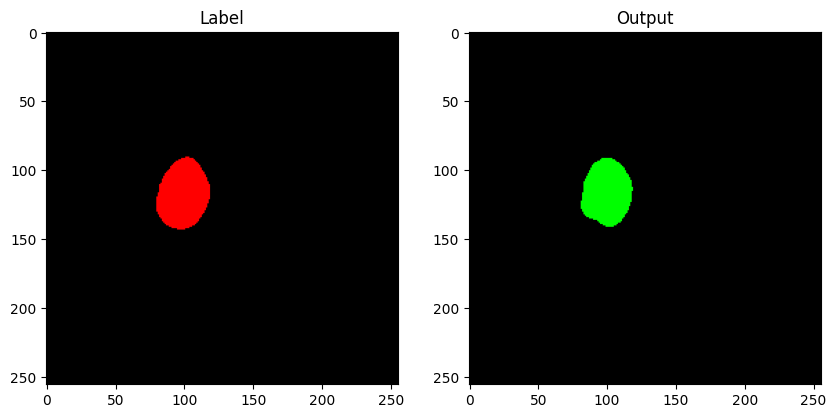

Epoch [105/125], Loss: 0.0619602307


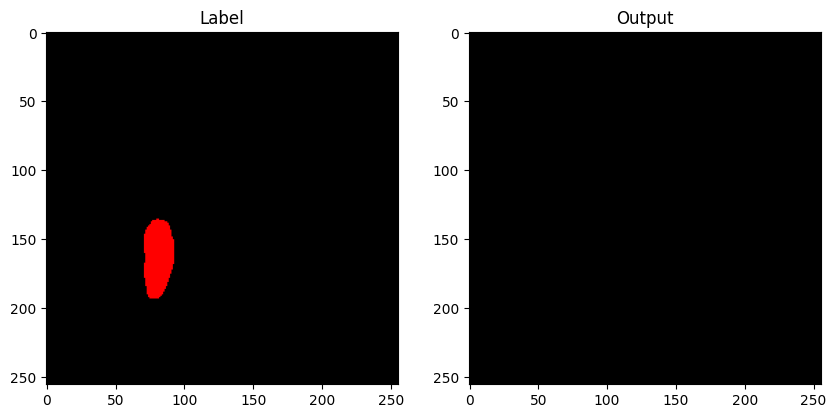

Epoch [106/125], Loss: 0.0739533420


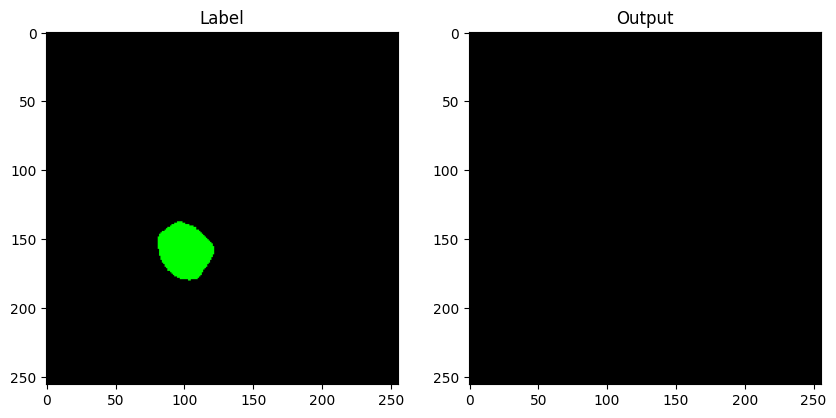

Epoch [107/125], Loss: 0.0695289983


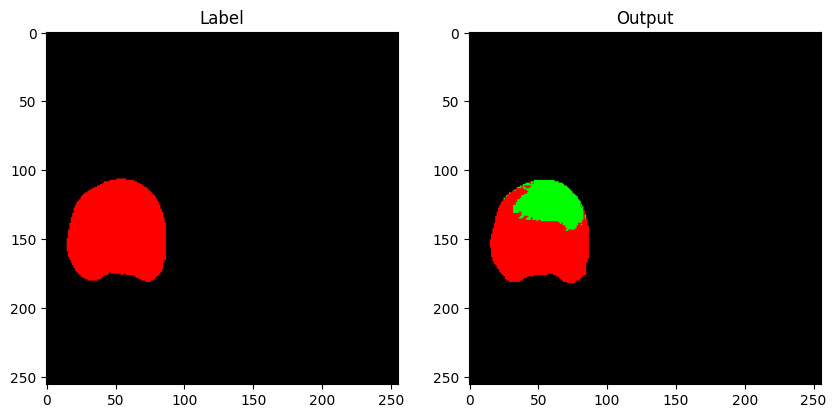

Epoch [108/125], Loss: 0.0702850957


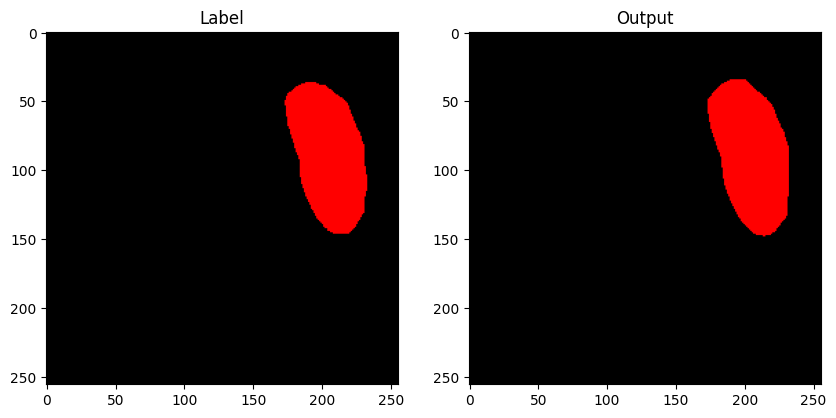

Epoch [109/125], Loss: 0.0720016165


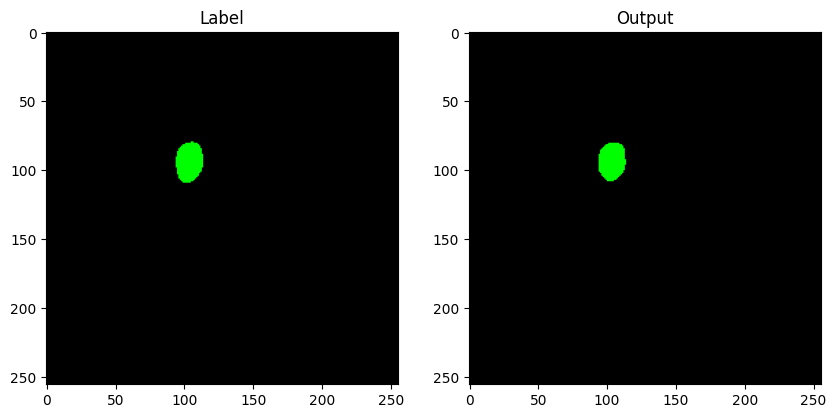

Epoch [110/125], Loss: 0.0708418845


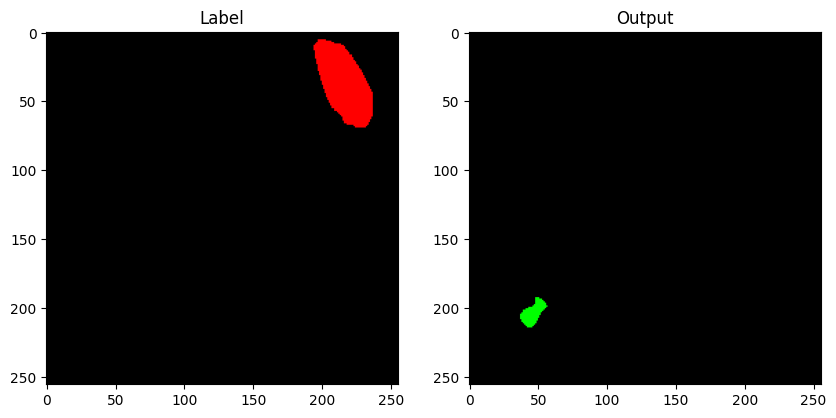

Epoch [111/125], Loss: 0.0707007129


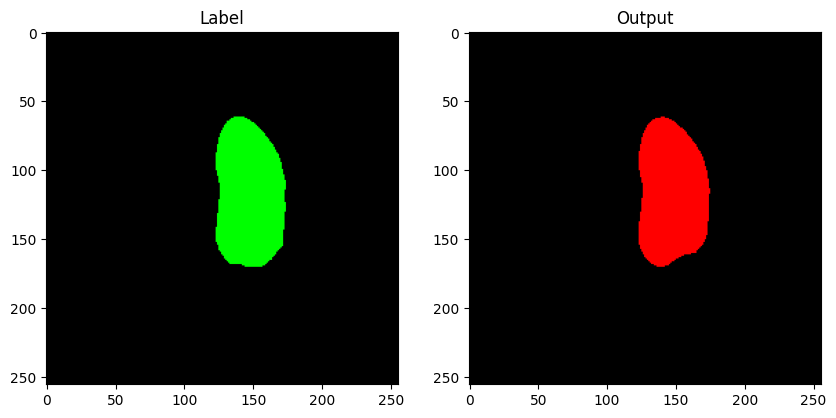

Epoch [112/125], Loss: 0.0773225890


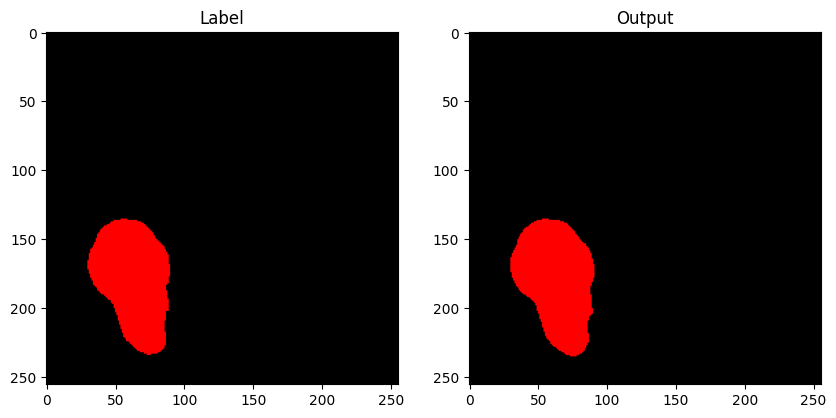

Epoch [113/125], Loss: 0.0809238373


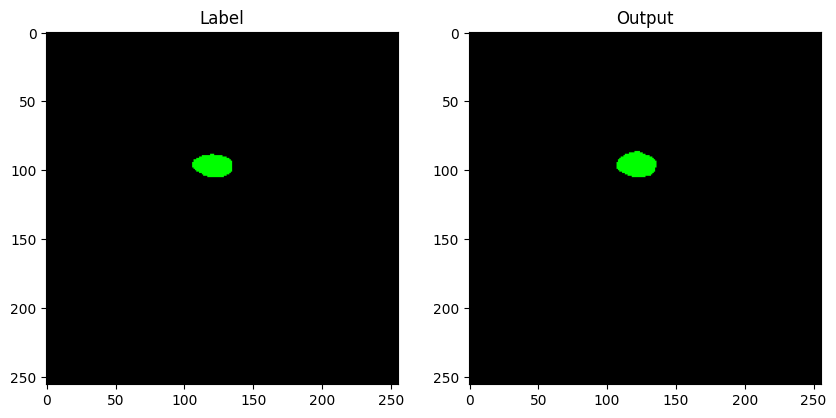

Epoch [114/125], Loss: 0.0621149351


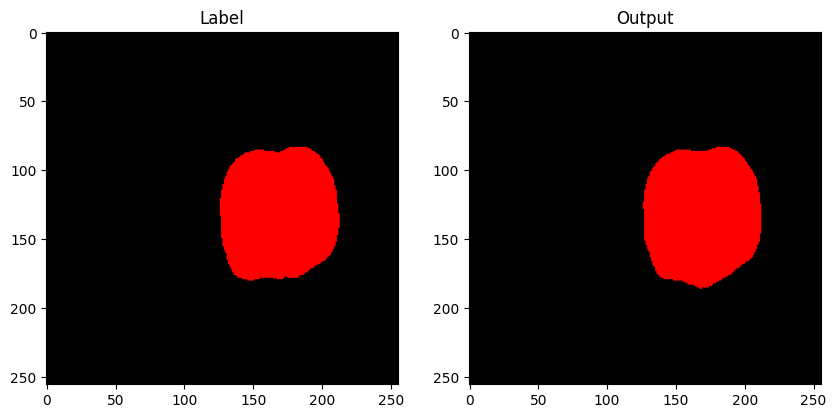

Epoch [115/125], Loss: 0.0804676189


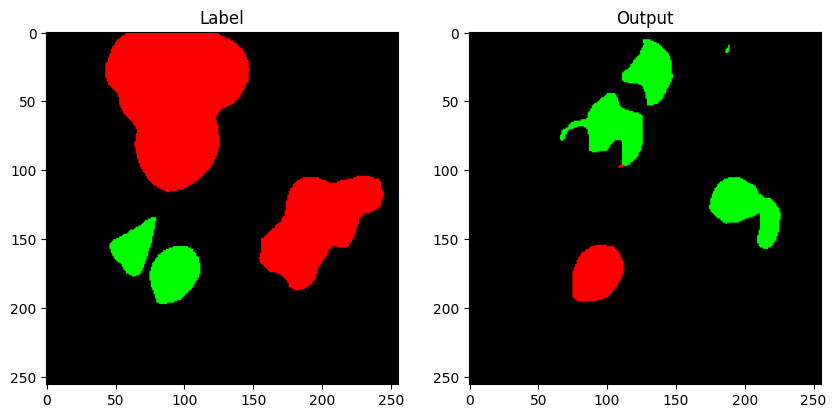

Epoch [116/125], Loss: 0.0729821523


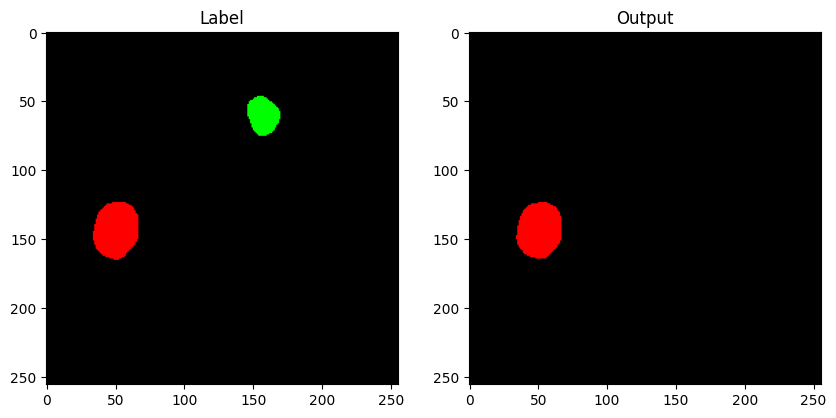

Epoch [117/125], Loss: 0.0759522993


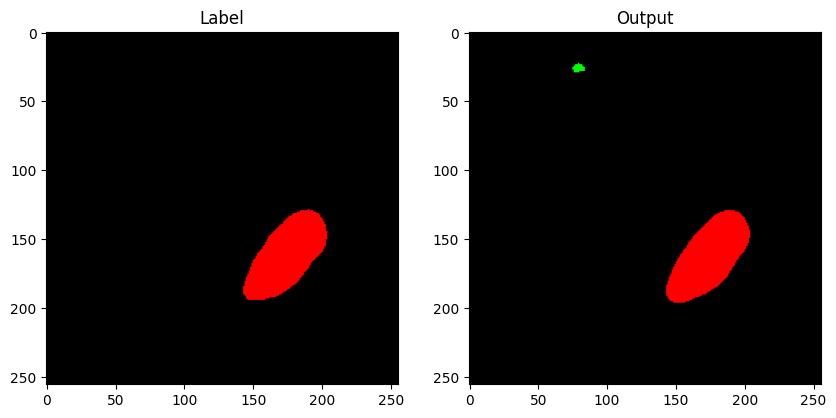

Epoch [118/125], Loss: 0.0815460430


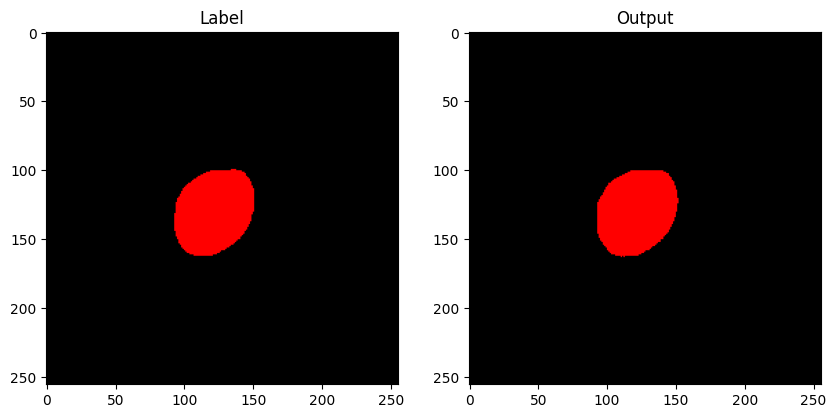

Epoch [119/125], Loss: 0.0848212999


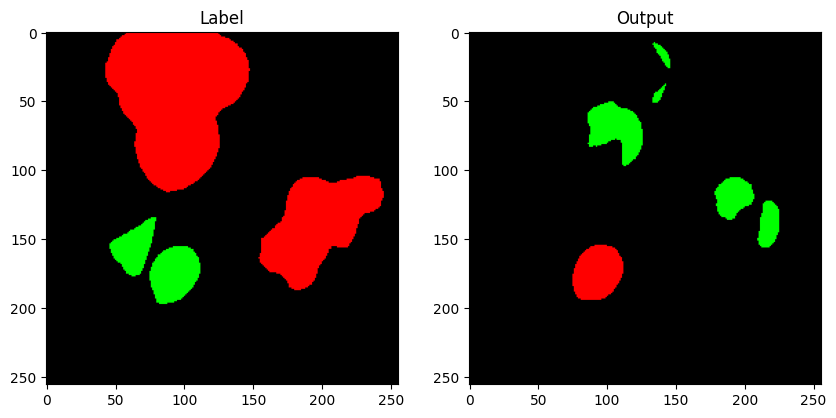

Epoch [120/125], Loss: 0.0722482209


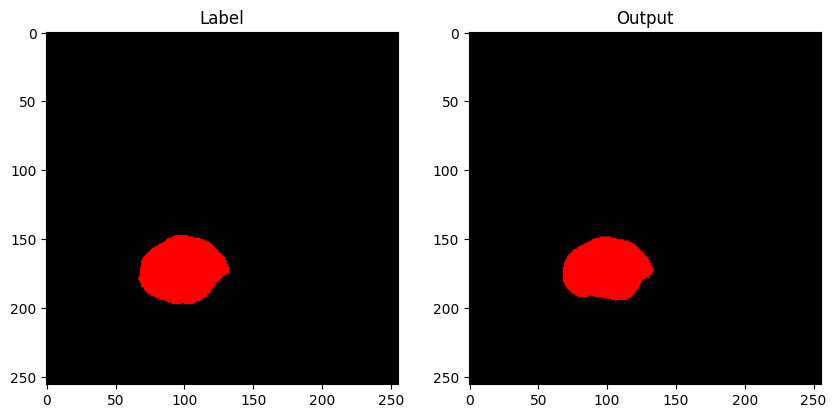

Epoch [121/125], Loss: 0.0714990085


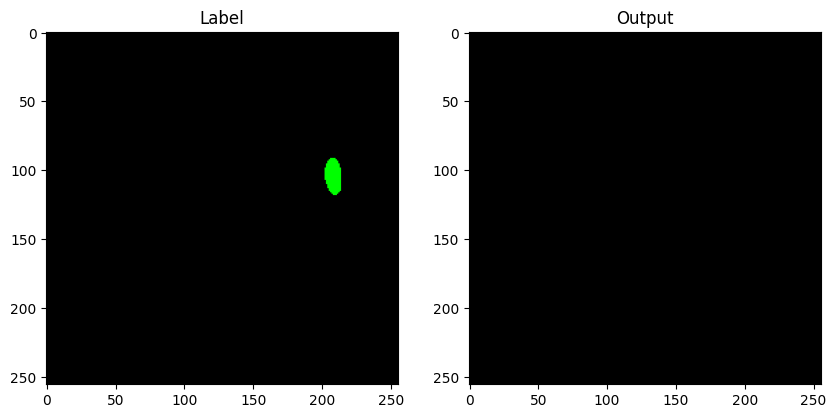

Epoch [122/125], Loss: 0.0768857185


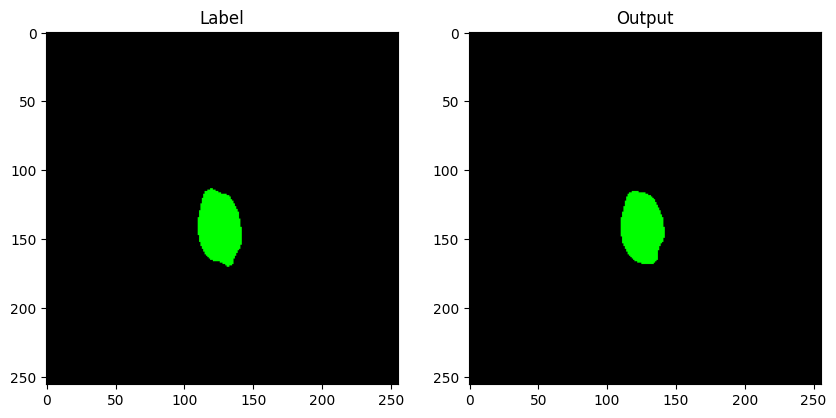

Epoch [123/125], Loss: 0.0704939949


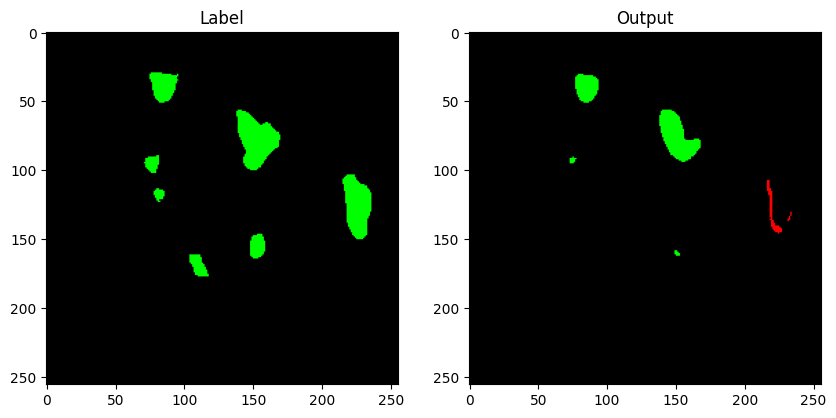

Epoch [124/125], Loss: 0.0765338602


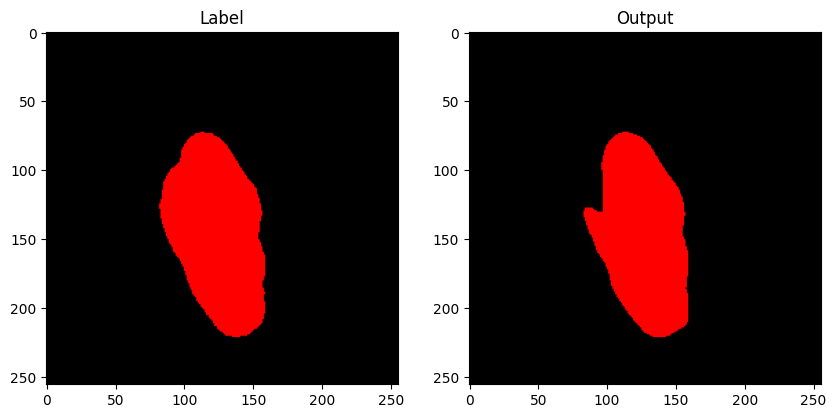

Epoch [125/125], Loss: 0.0643472332


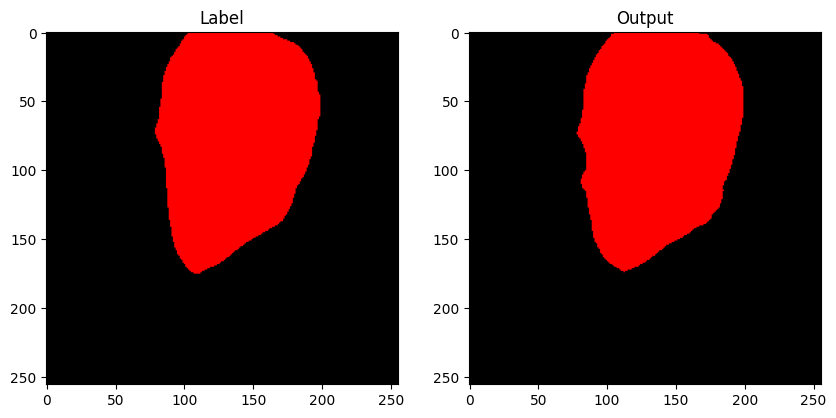

In [16]:
# Set the number of training epochs
num_epochs = 125

# Move the model to the device (e.g., GPU)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
best_val_loss = 999
# Training loop
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        labels = labels.squeeze(dim=1).long()
        outputs = model(images)
        # Compute the loss
    
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    # Perform validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(dim=1).long()
            
            # Forward pass
            outputs = model(images)
#             print(outputs.shape)

            val_loss += criterion(outputs.float(),labels.long()).item()

    # Print the loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss/len(val_loader):.10f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': val_loss,
        }
        save_path = f'colorization_model.pth'
        torch.save(checkpoint, save_path)
        print('Save new model')
    
    
    
    label = labels[0].cpu().numpy()
    label = mask_to_rgb(label,color_dict)
    outputs[0] = outputs[0].softmax(dim=0)
    output = outputs[0].cpu().numpy()
    output = np.argmax(output, axis=0)
    output = mask_to_rgb(output,color_dict)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(label)
    axs[0].set_title('Label')
    axs[1].imshow(output)
    axs[1].set_title('Output')
    plt.show()


In [21]:
checkpoint = torch.load('/kaggle/working/colorization_model.pth')
model.load_state_dict(checkpoint['model'])
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [22]:
!mkdir prediction

mkdir: cannot create directory ‘prediction’: File exists


In [23]:
trainsize = 256
model.eval()
for i in os.listdir("/kaggle/input/bkai-igh-neopolyp/test/test"):
    img_path = os.path.join("/kaggle/input/bkai-igh-neopolyp/test/test", i)
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_w = ori_img.shape[0]
    ori_h = ori_img.shape[1]
    img = cv2.resize(ori_img, (trainsize, trainsize))
    transformed = val_transform(image=img)
    input_img = transformed["image"]
    input_img = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output_mask = model.forward(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output_mask, (ori_h, ori_w))
    mask = np.argmax(mask, axis=2)
    new_rgb_mask = np.zeros((*mask.shape, 3)).astype(np.uint8)
    mask_rgb = mask_to_rgb(mask, color_dict)
    cv2.imwrite("predicted_mask/{}".format(i), mask_rgb)

     

In [24]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/prediction' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'output.csv', index=False)